# Project setup

## Dependencies

In [1]:
# Cell 0: Installations

#%pip install scikit-learn scikit-image
#%pip install SimpleITK
#%pip install nibabel nilearn scipy scikit-image
#%pip install albumentations
#%pip install gc
#%pip install seaborn


In [2]:
# Cell 1: Import necessary libraries

# Dataset handling and ingestion
import os
import pandas as pd
import numpy as np

# Image processing
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars
import seaborn as sns

# Exploratory data analysis
import time
import gc
import psutil
import torch
from scipy import stats

# Preprocessing
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import ndimage
from scipy.ndimage import zoom
from skimage import filters
from skimage.morphology import binary_dilation, binary_erosion, ball
import nibabel as nib

## Dataset loading

In [3]:
# Cell 2: Load and process the CSV file with exam information
csv_path = os.path.join('Images', 'idaSearch.csv')
exam_info_df = pd.read_csv(csv_path)

# Define the base directory and categories
base_dir = 'Images'
categories = ['PPMI_Images_PD', 'PPMI_Images_SWEDD', 'PPMI_Images_Cont']

In [4]:
# Cell 3: Collect DICOM file paths for each category
data = []

for category in categories:
    category_path = os.path.join(base_dir, category)
    for patient_id in os.listdir(category_path):
        patient_path = os.path.join(category_path, patient_id)
        reconstructed_path = os.path.join(patient_path, 'Reconstructed_DaTSCAN')
        if os.path.exists(reconstructed_path):
            for exam_date in os.listdir(reconstructed_path):
                exam_date_path = os.path.join(reconstructed_path, exam_date)
                for exam_id in os.listdir(exam_date_path):
                    exam_id_path = os.path.join(exam_date_path, exam_id)
                    for root, dirs, files in os.walk(exam_id_path):
                        for file in files:
                            if file.endswith('.dcm'):
                                file_path = os.path.join(root, file)
                                # Controlliamo che non sia un'immagine raw
                                if 'br_raw_' not in file_path:
                                    data.append({
                                        'category': category,
                                        'patient_id': patient_id,
                                        'file_path': file_path
                                    })

In [5]:
# Cell 4: Create a DataFrame to organize the data
df = pd.DataFrame(data)
df['label'] = df['category'].map({
    'PPMI_Images_PD': 'PD',
    'PPMI_Images_SWEDD': 'SWEDD',
    'PPMI_Images_Cont': 'Control'
})
df = df[['patient_id', 'file_path', 'label']]

loaded_patients = df['patient_id'].unique()
print("\nLoading statistics:")
print(f"Total unique patients loaded: {len(loaded_patients)}")
print(f"Patients loaded per category:")
for category in df['label'].unique():
    cat_patients = df[df['label'] == category]['patient_id'].nunique()
    print(f"- {category}: {cat_patients} patients")


Loading statistics:
Total unique patients loaded: 1651
Patients loaded per category:
- PD: 1283 patients
- SWEDD: 79 patients
- Control: 289 patients


In [6]:
# Cell 5: Summary statistics
print('Number of images per category:')
print(df['label'].value_counts())
print('\nNumber of unique patients per category:')
for label in df['label'].unique():
    n_patients = df[df['label'] == label]['patient_id'].nunique()
    print(f"{label}: {n_patients} patients")


Number of images per category:
label
PD         2555
Control     294
SWEDD       137
Name: count, dtype: int64

Number of unique patients per category:
PD: 1283 patients
SWEDD: 79 patients
Control: 289 patients


In [7]:
# Cell 6: Save DataFrame to CSV (optional)
df.to_csv('dicom_file_paths.csv', index=False)

# EDA (Data Prep)

In [8]:
# Cell 7: Functions to load and preprocess DICOM images
def load_dicom_image(file_path, target_shape=None):
    """
    Load a DICOM file and return the image data as a NumPy array.
    Optionally resizes the image to the target_shape.
    """
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array.astype(np.float32)
    
    # Apply rescale slope and intercept if present
    if 'RescaleSlope' in ds:
        img *= float(ds.RescaleSlope)
    if 'RescaleIntercept' in ds:
        img += float(ds.RescaleIntercept)
    
    # Normalize the image intensities
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # # Resize image if target_shape is specified
    # if target_shape and img.shape != target_shape:
    #     from skimage.transform import resize
    #     img = resize(img, target_shape, mode='reflect', anti_aliasing=True)
    
    return img

def print_dicom_orientation(dicom_path):
    """
    Stampa le informazioni di orientamento dal file DICOM
    """
    ds = pydicom.dcmread(dicom_path)
    print("\nDICOM Orientation Info:")
    for tag in ['ImageOrientationPatient', 'ImagePositionPatient', 'PixelSpacing']:
        if tag in ds:
            print(f"{tag}: {ds[tag].value}")

def debug_volume_visualization(mean_img, title="Debug Volume View"):
    """
    Visualize the 3D volume more appropriately for DATSCAN

    Visualizza il volume 3D in modo più appropriato per DATSCAN
    """
    print(f"Volume shape: {mean_img.shape}")
    
    # Extract the central planes in three directions
    center_x = mean_img.shape[0] // 2
    center_y = mean_img.shape[1] // 2
    center_z = mean_img.shape[2] // 2
    
    # Visualize raw data without manipulations
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"{title} - Raw Data Views")
    
    # First row: raw data
    axes[0,0].imshow(mean_img[center_x, :, :], cmap='gray')
    axes[0,0].set_title('YZ plane (raw)')
    axes[0,1].imshow(mean_img[:, center_y, :], cmap='gray')
    axes[0,1].set_title('XZ plane (raw)')
    axes[0,2].imshow(mean_img[:, :, center_z], cmap='gray')
    axes[0,2].set_title('XY plane (raw)')
    
    # Second row: histograms intensity distributions
    axes[1,0].hist(mean_img[center_x, :, :].ravel(), bins=50)
    axes[1,0].set_title('YZ intensity distribution')
    axes[1,1].hist(mean_img[:, center_y, :].ravel(), bins=50)
    axes[1,1].set_title('XZ intensity distribution')
    axes[1,2].hist(mean_img[:, :, center_z].ravel(), bins=50)
    axes[1,2].set_title('XY intensity distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Some statistics
    print("\nStatistics per plane:")
    print(f"YZ plane - min: {mean_img[center_x, :, :].min():.3f}, max: {mean_img[center_x, :, :].max():.3f}")
    print(f"XZ plane - min: {mean_img[:, center_y, :].min():.3f}, max: {mean_img[:, center_y, :].max():.3f}")
    print(f"XY plane - min: {mean_img[:, :, center_z].min():.3f}, max: {mean_img[:, :, center_z].max():.3f}")

    return mean_img

In [9]:
# Cell 8: Initialize dictionaries to store sums and counts for each group
mean_sums = {'PD': None, 'SWEDD': None, 'Control': None}
counts = {'PD': 0, 'SWEDD': 0, 'Control': 0}
shapes = {'PD': None, 'SWEDD': None, 'Control': None}


In [10]:
# Cell 9: Compute mean images for each group
# We'll iterate over the DataFrame 'df' created earlier

# Map labels to group names
group_labels = {'PD': 'PD', 'SWEDD': 'SWEDD', 'Control': 'Control'}

# Iterate over each group
for label in group_labels.values():
    group_df = df[df['label'] == label]
    print(f"Processing group: {label}")
    
    # Initialize progress bar
    for idx, row in tqdm(group_df.iterrows(), total=group_df.shape[0]):
        file_path = row['file_path']
        try:
            # Load the image
            if counts[label] == 0:
                # For the first image, get the shape
                img = load_dicom_image(file_path)
                shapes[label] = img.shape
                mean_sums[label] = np.zeros(shapes[label], dtype=np.float32)
            else:
                # For subsequent images, resize if necessary
                img = load_dicom_image(file_path, target_shape=shapes[label])
            
            # Accumulate the sum
            mean_sums[label] += img
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    # Compute the mean
    mean_sums[label] /= counts[label]


Processing group: PD


  5%|▍         | 115/2555 [00:00<00:18, 133.51it/s]

Error processing Images\PPMI_Images_PD\101281\Reconstructed_DaTSCAN\2021-04-13_13_45_25.0\I1474392\PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (91,109,91) (48,128,128) (91,109,91) 


 33%|███▎      | 843/2555 [00:06<00:12, 137.69it/s]

Error processing Images\PPMI_Images_PD\3078\Reconstructed_DaTSCAN\2016-04-26_15_13_55.0\I1317553\PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (91,109,91) (120,128,128) (91,109,91) 
Error processing Images\PPMI_Images_PD\3078\Reconstructed_DaTSCAN\2016-04-26_15_13_55.0\I1317553\PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (91,109,91) (120,128,128) (91,109,91) 


 35%|███▍      | 884/2555 [00:06<00:13, 119.42it/s]

Error processing Images\PPMI_Images_PD\3107\Reconstructed_DaTSCAN\2016-04-05_13_38_35.0\I770243\PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (91,109,91) (360,128,128) (91,109,91) 


 39%|███▉      | 996/2555 [00:07<00:14, 108.26it/s]

Error processing Images\PPMI_Images_PD\3179\Reconstructed_DaTSCAN\2016-08-18_13_51_47.0\I1317564\PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (91,109,91) (480,128,128) (91,109,91) 


 47%|████▋     | 1206/2555 [00:09<00:11, 114.64it/s]

Error processing Images\PPMI_Images_PD\3372\Reconstructed_DaTSCAN\2016-04-27_14_22_11.0\I1317554\PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (91,109,91) (256,128,128) (91,109,91) 
Error processing Images\PPMI_Images_PD\3372\Reconstructed_DaTSCAN\2016-04-27_14_22_11.0\I1317554\PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (91,109,91) (256,128,128) (91,109,91) 


 56%|█████▌    | 1426/2555 [00:11<00:10, 105.66it/s]

Error processing Images\PPMI_Images_PD\3500\Reconstructed_DaTSCAN\2015-12-02_09_47_00.0\I770244\PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (91,109,91) (120,128,128) (91,109,91) 


 72%|███████▏  | 1851/2555 [00:14<00:06, 103.30it/s]

Error processing Images\PPMI_Images_PD\3863\Reconstructed_DaTSCAN\2013-03-13_13_29_21.0\I449248\PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (91,109,91) (60,128,128) (91,109,91) 


100%|██████████| 2555/2555 [00:19<00:00, 130.17it/s]


Processing group: SWEDD


100%|██████████| 137/137 [00:00<00:00, 145.15it/s]


Processing group: Control


100%|██████████| 294/294 [00:02<00:00, 106.64it/s]



Single DICOM control analysis:

DICOM Orientation Info:
PixelSpacing: [2.0, 2.0]

Debug visualization for PD group:
Volume shape: (91, 109, 91)


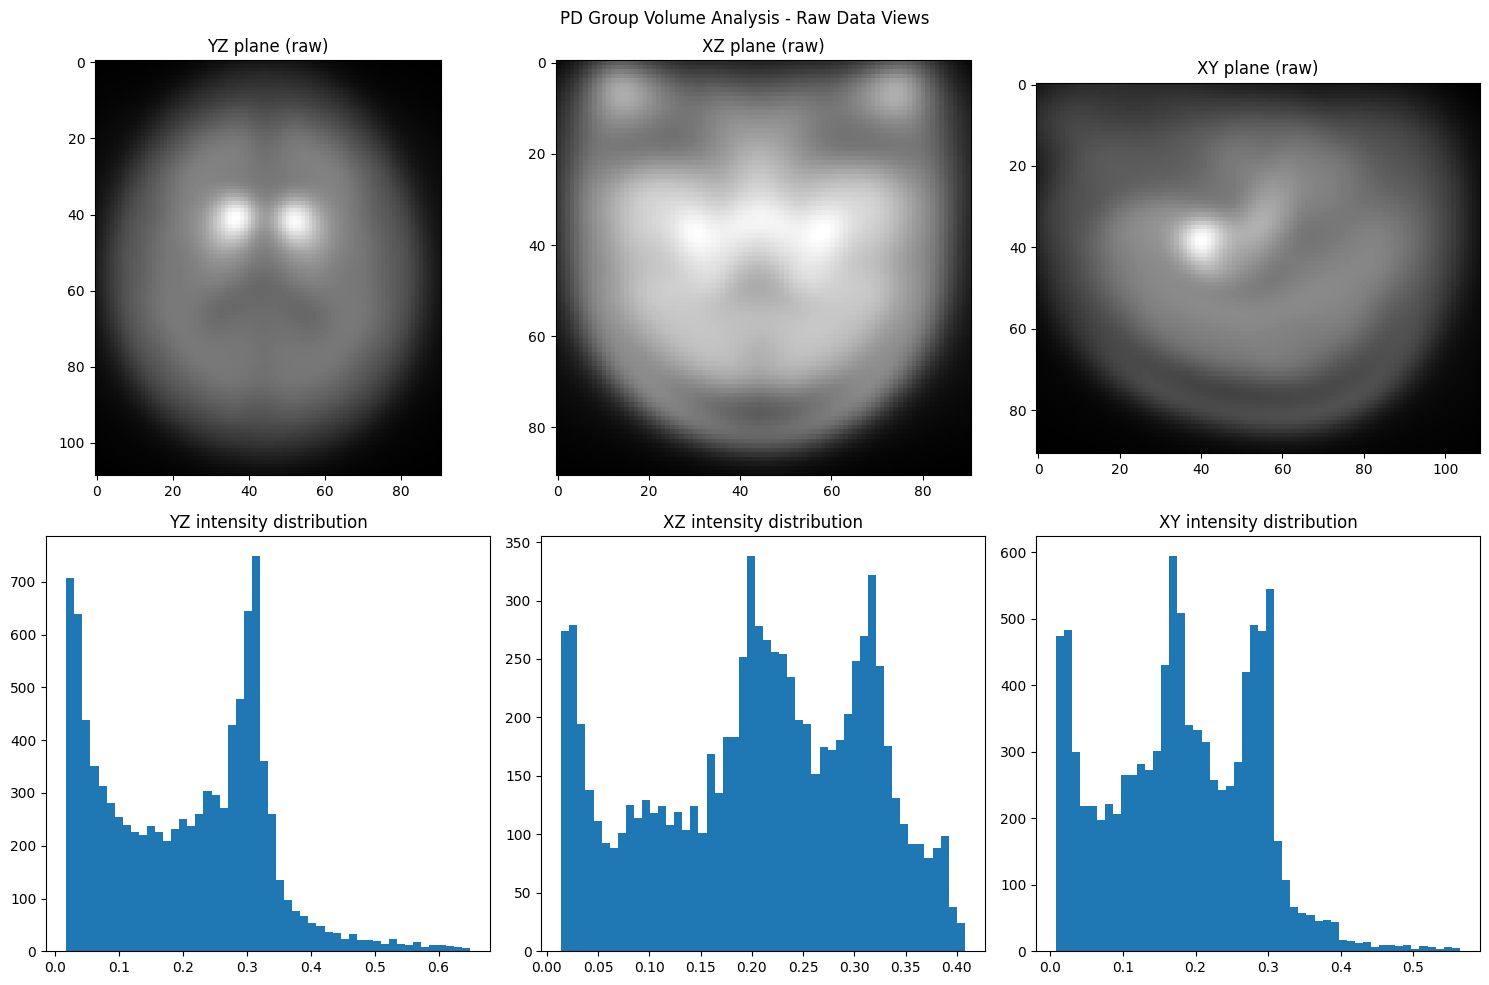


Statistics per plane:
YZ plane - min: 0.017, max: 0.649
XZ plane - min: 0.014, max: 0.408
XY plane - min: 0.008, max: 0.564

Debug visualization for SWEDD group:
Volume shape: (91, 109, 91)


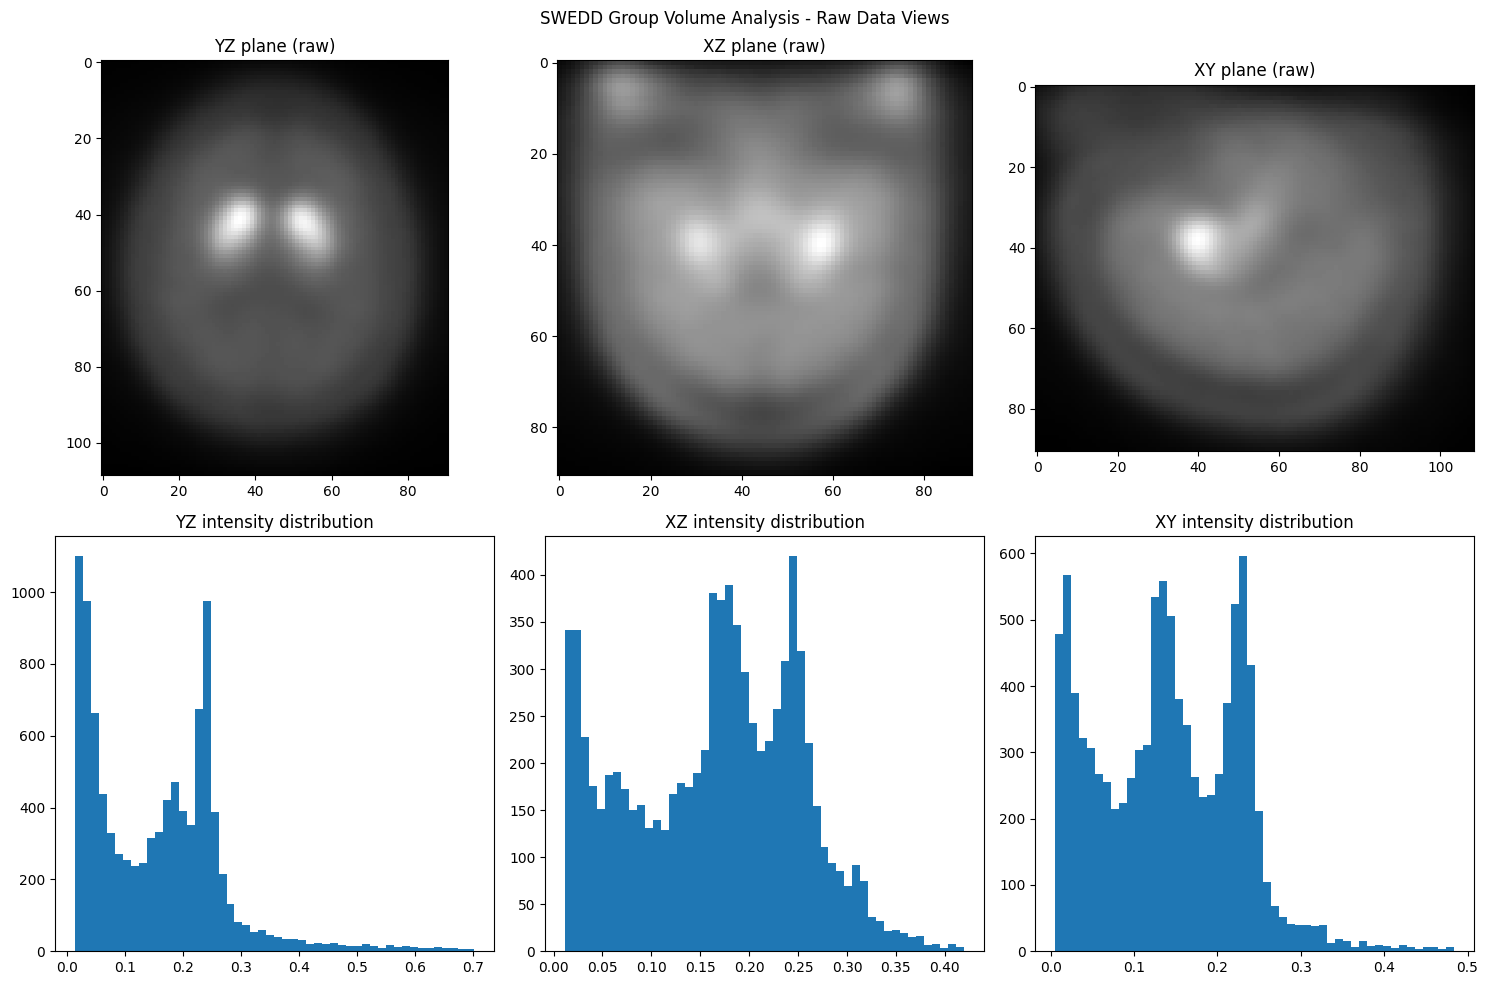


Statistics per plane:
YZ plane - min: 0.013, max: 0.702
XZ plane - min: 0.012, max: 0.420
XY plane - min: 0.005, max: 0.484

Debug visualization for Control group:
Volume shape: (91, 109, 91)


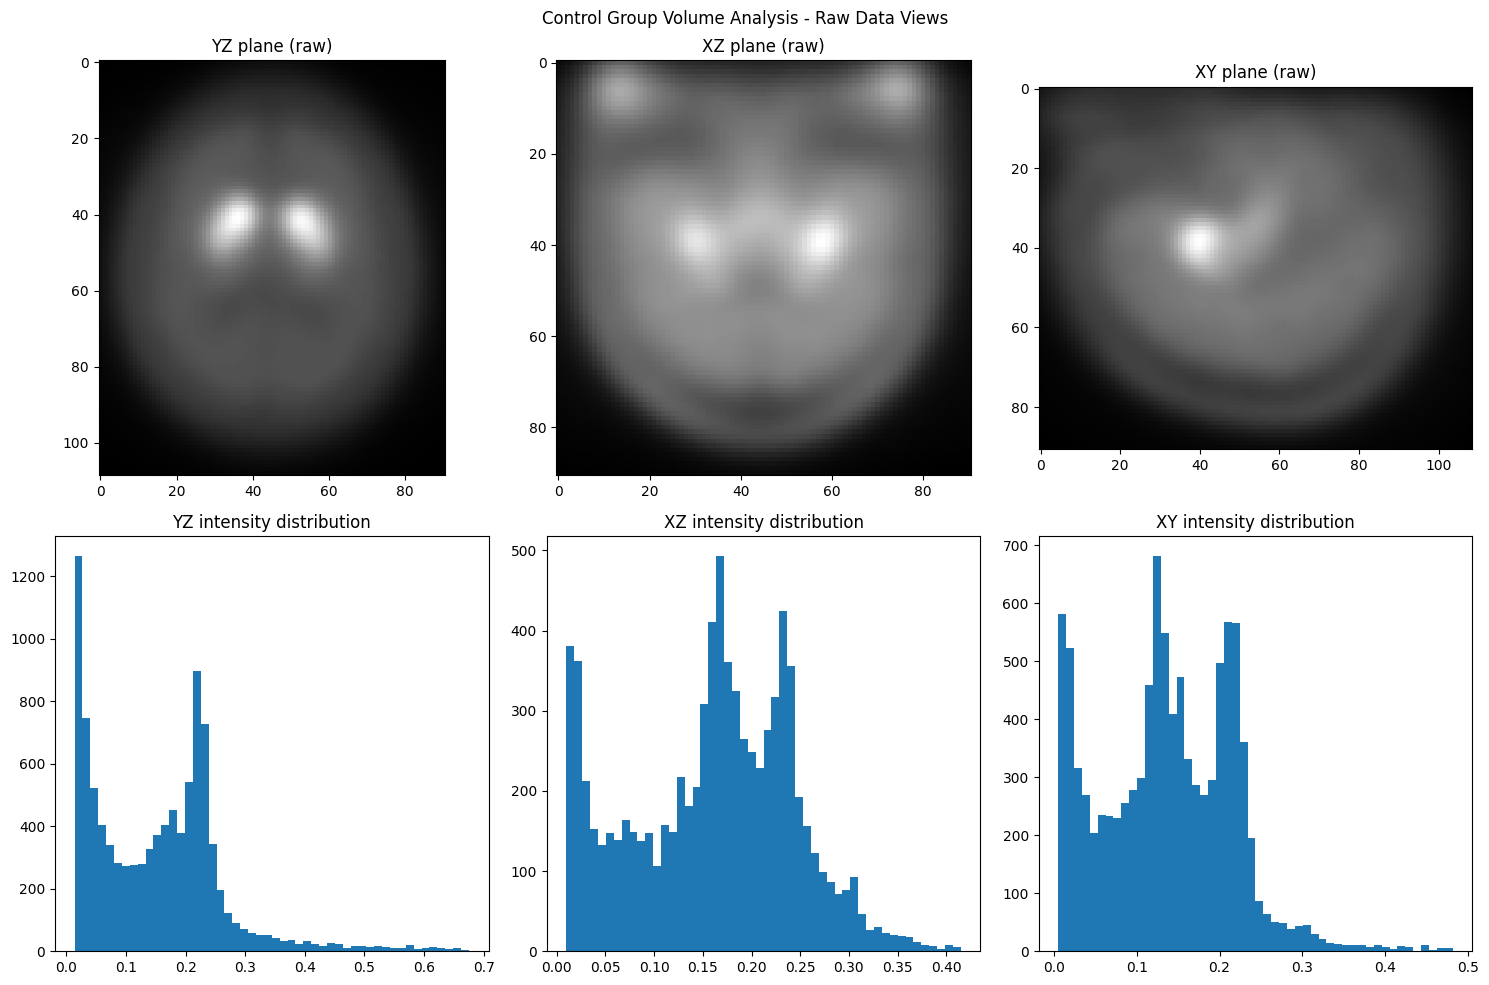


Statistics per plane:
YZ plane - min: 0.014, max: 0.675
XZ plane - min: 0.010, max: 0.415
XY plane - min: 0.005, max: 0.481


In [11]:
# Cell 10: Visualize the mean images and debug information
first_control_file = df[df['label'] == 'Control']['file_path'].iloc[0]
print("\nSingle DICOM control analysis:")
print_dicom_orientation(first_control_file)

# Debug information for each group
for label in ['PD', 'SWEDD', 'Control']:
    print(f"\nDebug visualization for {label} group:")
    debug_volume_visualization(mean_sums[label], title=f"{label} Group Volume Analysis")

In [12]:
# Cell 11: Visualize the mean images for each group with corrected orientation
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_views(mean_img, title_prefix):
    """
    Plots the axial, coronal, and sagittal views of the mean image with corrected orientation.
    Each image is rotated counterclockwise by 90 degrees.
    """
    # Swap axes if necessary to match anatomical planes
    # This rearranges the data from (Z, Y, X) to (X, Y, Z)
    mean_img = np.swapaxes(mean_img, 0, 2)

    # Compute the middle slices
    axial_slice = mean_img[:, :, mean_img.shape[2] // 2]
    coronal_slice = mean_img[:, mean_img.shape[1] // 2, :]
    sagittal_slice = mean_img[mean_img.shape[0] // 2, :, :]

    # Adjust the orientation of slices
    # First, flip slices to correct the orientation
    axial_slice = np.flipud(axial_slice)
    coronal_slice = np.flipud(coronal_slice)
    sagittal_slice = np.flipud(sagittal_slice)

    # Then, rotate each slice counterclockwise by 90 degrees
    axial_slice = np.rot90(axial_slice, k=1)
    coronal_slice = np.rot90(coronal_slice, k=1)
    sagittal_slice = np.rot90(sagittal_slice, k=1)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plt.suptitle(f"{title_prefix} Mean Views")

    axes[0].imshow(axial_slice, cmap='gray', origin='upper')
    axes[0].set_title('Axial View')
    axes[0].axis('off')

    axes[1].imshow(coronal_slice, cmap='gray', origin='upper')
    axes[1].set_title('Coronal View')
    axes[1].axis('off')

    axes[2].imshow(sagittal_slice, cmap='gray', origin='upper')
    axes[2].set_title('Sagittal View')
    axes[2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


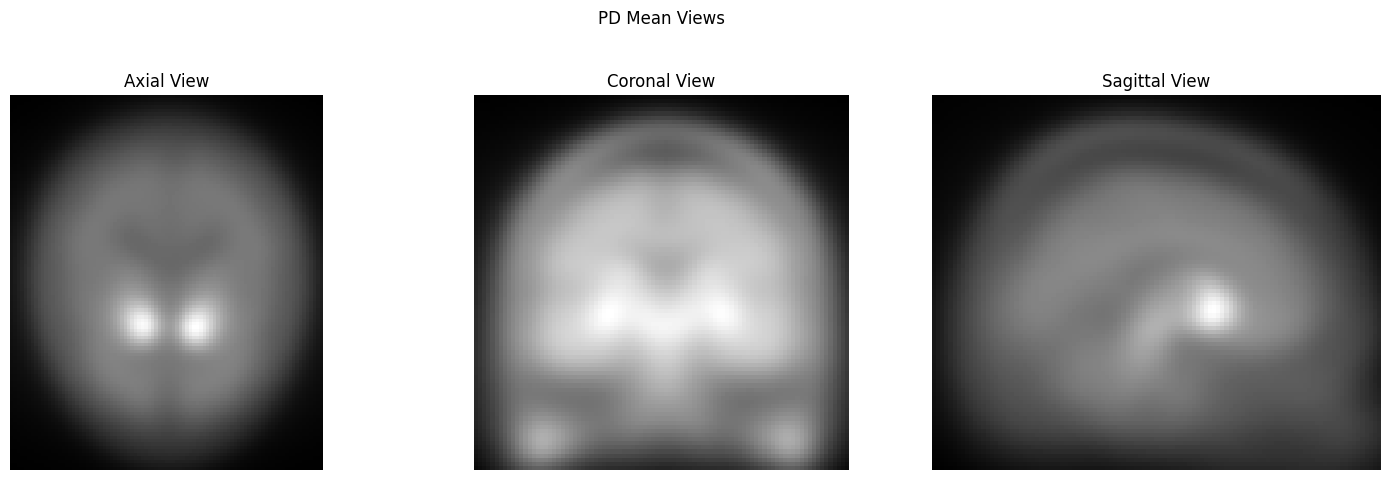

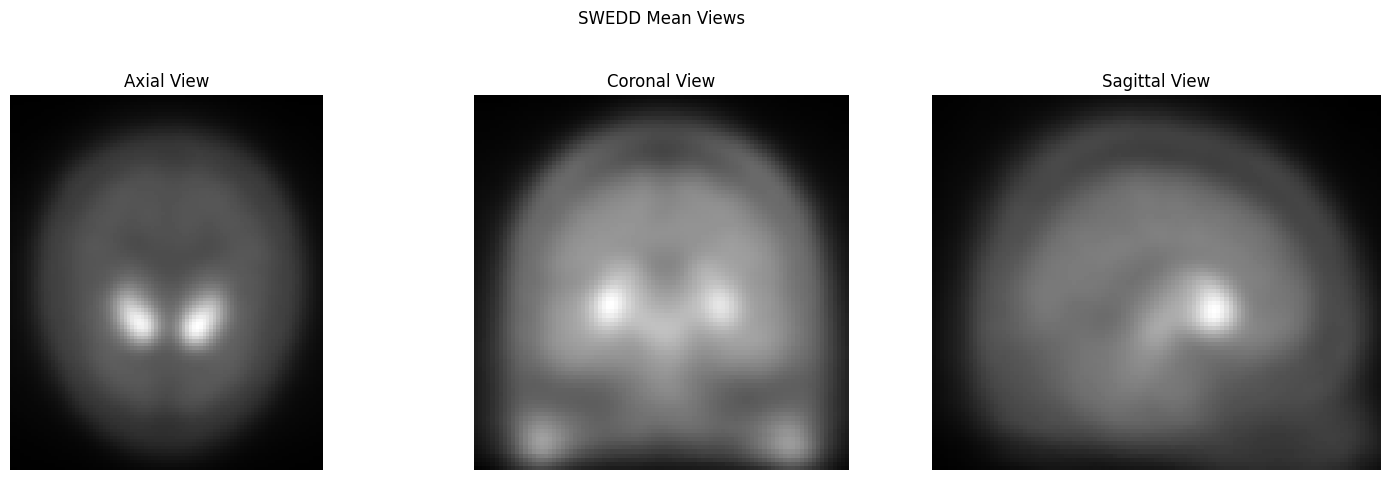

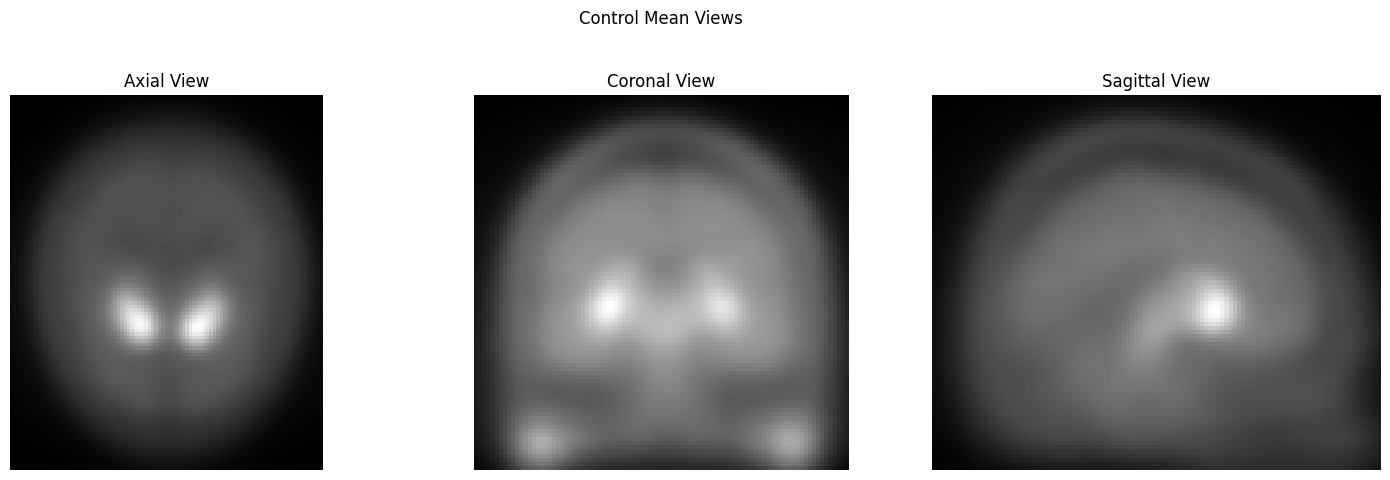

In [13]:
# Cell 12: Plot the mean views for each group
for label in group_labels.values():
    mean_img = mean_sums[label]
    plot_mean_views(mean_img, title_prefix=label)


Selected Random Patients:
PD: Patient ID 139117
SWEDD: Patient ID 3101
Control: Patient ID 3966
Visualizing Patient ID 139117 - File: Images\PPMI_Images_PD\139117\Reconstructed_DaTSCAN\2021-10-13_11_57_24.0\I1574633\PPMI_139117_NM_Reconstructed_DaTSCAN_Br_20220428101425358_1_S1128611_I1574633.dcm


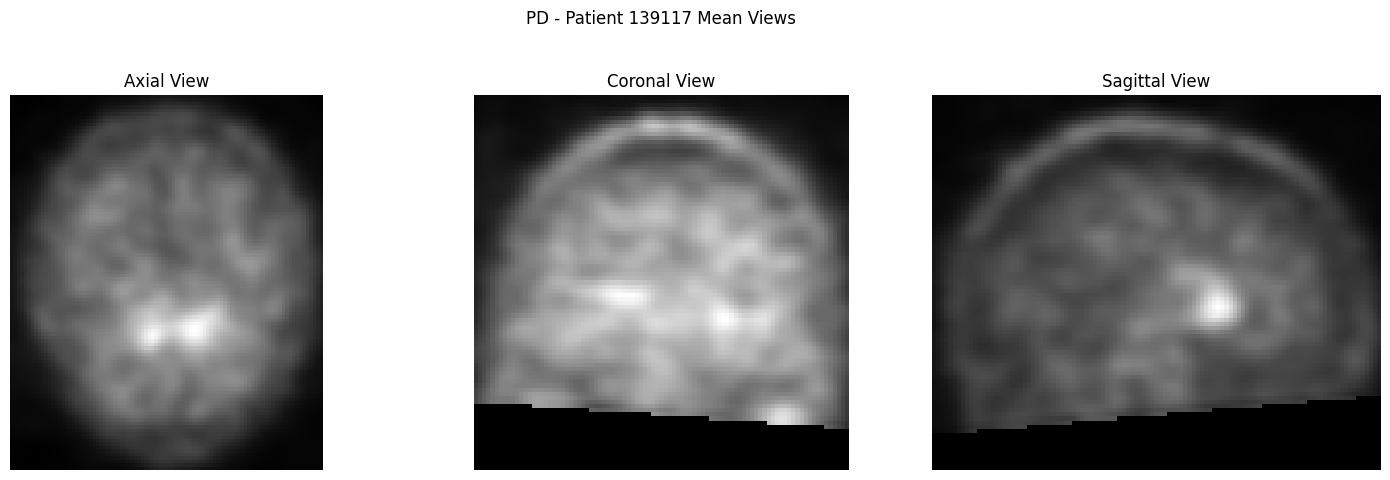

Visualizing Patient ID 3101 - File: Images\PPMI_Images_SWEDD\3101\Reconstructed_DaTSCAN\2014-08-22_13_07_50.0\I504396\PPMI_3101_NM_Reconstructed_DaTSCAN_Br_20150807093019408_1_S237564_I504396.dcm


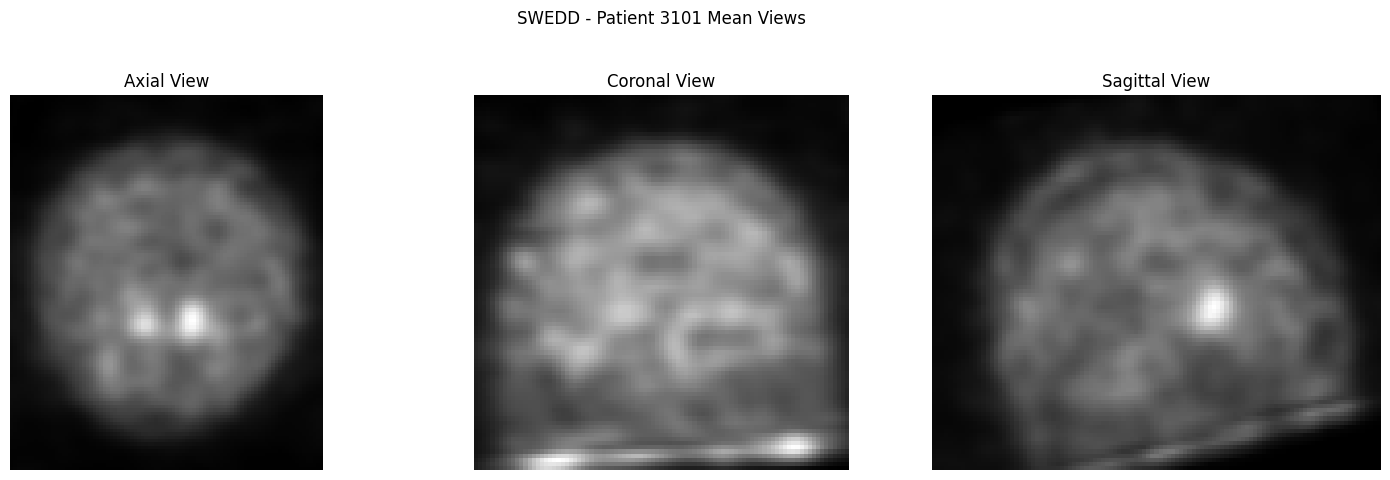

Visualizing Patient ID 3966 - File: Images\PPMI_Images_Cont\3966\Reconstructed_DaTSCAN\2013-02-07_16_22_39.0\I388574\PPMI_3966_NM_Reconstructed_DaTSCAN_Br_20130909140447954_1_S191678_I388574.dcm


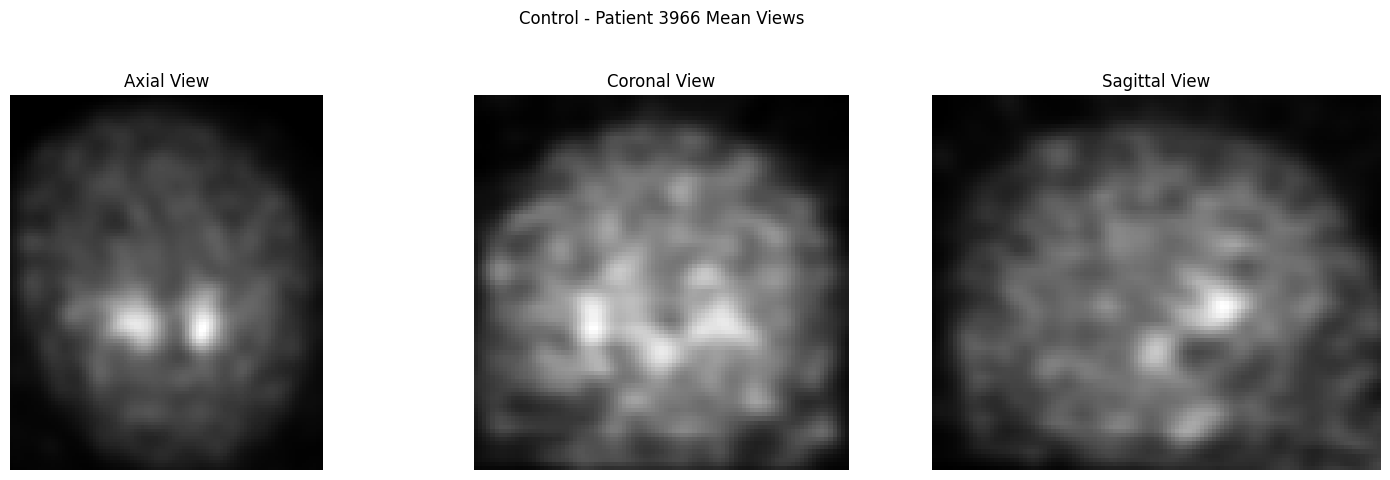

In [14]:
# Cell 13: Select and visualize a random patient from each group

import random

# Function to select a random patient from each group
def select_random_patients(df, groups):
    random_patients = {}
    for group in groups:
        group_df = df[df['label'] == group]
        unique_patients = group_df['patient_id'].unique()
        if len(unique_patients) == 0:
            print(f"No patients found in group: {group}")
            continue
        selected_patient = random.choice(unique_patients)
        random_patients[group] = selected_patient
    return random_patients

# Define the groups
groups = ['PD', 'SWEDD', 'Control']

# Select random patients
random_patients = select_random_patients(df, groups)
print("Selected Random Patients:")
for group, patient in random_patients.items():
    print(f"{group}: Patient ID {patient}")

    # Function to visualize a random image for a given patient
def visualize_random_patient(df, patient_id, label):
    """
    Select a random DICOM file for the given patient and plot its views.
    """
    patient_df = df[(df['patient_id'] == patient_id) & (df['label'] == label)]
    if patient_df.empty:
        print(f"No images found for Patient ID {patient_id} in group {label}.")
        return
    
    # Select a random image
    random_file = random.choice(patient_df['file_path'].tolist())
    print(f"Visualizing Patient ID {patient_id} - File: {random_file}")
    
    # Load the image
    img = load_dicom_image(random_file)
    
    # Plot the views
    plot_mean_views(img, title_prefix=f"{label} - Patient {patient_id}")

# Iterate over each group and visualize a random patient
for group, patient_id in random_patients.items():
    visualize_random_patient(df, patient_id, group)

## EDA

In [15]:
# Cell 14: Configure GPU settings and memory monitoring
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def get_memory_usage():
    """
    Get current memory usage of the system and GPU if available
    """
    # System memory
    process = psutil.Process()
    system_memory = process.memory_info().rss / 1024 / 1024  # MB
    
    # GPU memory
    gpu_memory = None
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024  # MB
    
    return system_memory, gpu_memory

if torch.cuda.is_available():
    # Print GPU info
    print(f"GPU Name: {torch.cuda.get_device_name()}")
    print(f"GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Set memory management options
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4070 Ti
GPU Memory Available: 12.88 GB


In [16]:
# Cell 15: Enhanced image statistics computation with memory tracking
def compute_image_statistics(img):
    """
    Compute comprehensive statistics for a 3D image
    """
    stats_dict = {
        'mean': float(np.mean(img)),  # Convert to native Python types
        'std': float(np.std(img)),
        'min': float(np.min(img)),
        'max': float(np.max(img)),
        'median': float(np.median(img)),
        'skewness': float(stats.skew(img.flatten())),
        'kurtosis': float(stats.kurtosis(img.flatten())),
        'num_zeros': int(np.sum(img == 0)),
        'num_non_zeros': int(np.sum(img != 0)),
        'volume': int(img.size),
        'dimensions': img.shape
    }
    
    # Compute histogram data
    hist, bins = np.histogram(img.flatten(), bins=50)
    stats_dict['histogram'] = {
        'counts': hist.tolist(),  # Convert to list for better memory management
        'bins': bins.tolist()
    }
    
    return stats_dict

In [17]:
# Cell 16: Batch process images with improved memory management
def process_group_statistics(group_df, batch_size=5):
    """
    Process images in batches with memory monitoring
    """
    statistics = []
    
    # Create progress bar for the entire dataset
    with tqdm(total=len(group_df), desc="Processing images") as pbar:
        for start_idx in range(0, len(group_df), batch_size):
            end_idx = min(start_idx + batch_size, len(group_df))
            batch_df = group_df.iloc[start_idx:end_idx]
            
            for _, row in batch_df.iterrows():
                try:
                    img = load_dicom_image(row['file_path'])
                    stats = compute_image_statistics(img)
                    stats['patient_id'] = row['patient_id']
                    statistics.append(stats)
                    del img
                except Exception as e:
                    tqdm.write(f"Error processing {row['file_path']}: {e}")
                
                pbar.update(1)
            
            # Clean up memory after batch
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    return statistics

In [18]:
# Cell 17: Process statistics for each group with progress tracking
group_statistics = {}
group_labels = {'PD': 'PD', 'SWEDD': 'SWEDD', 'Control': 'Control'}  # Move this here for clarity

for label in group_labels.values():
    print(f"\nProcessing statistics for {label} group...")
    start_time = time.time()
    
    group_df = df[df['label'] == label]
    group_statistics[label] = process_group_statistics(group_df)
    
    duration = time.time() - start_time
    print(f"Completed {label} group in {duration:.2f} seconds")
    print(f"Processed {len(group_statistics[label])} images")


Processing statistics for PD group...


Processing images: 100%|██████████| 2555/2555 [02:11<00:00, 19.42it/s]


Completed PD group in 131.57 seconds
Processed 2555 images

Processing statistics for SWEDD group...


Processing images: 100%|██████████| 137/137 [00:06<00:00, 19.77it/s]


Completed SWEDD group in 6.93 seconds
Processed 137 images

Processing statistics for Control group...


Processing images: 100%|██████████| 294/294 [00:15<00:00, 18.55it/s]

Completed Control group in 15.86 seconds
Processed 294 images


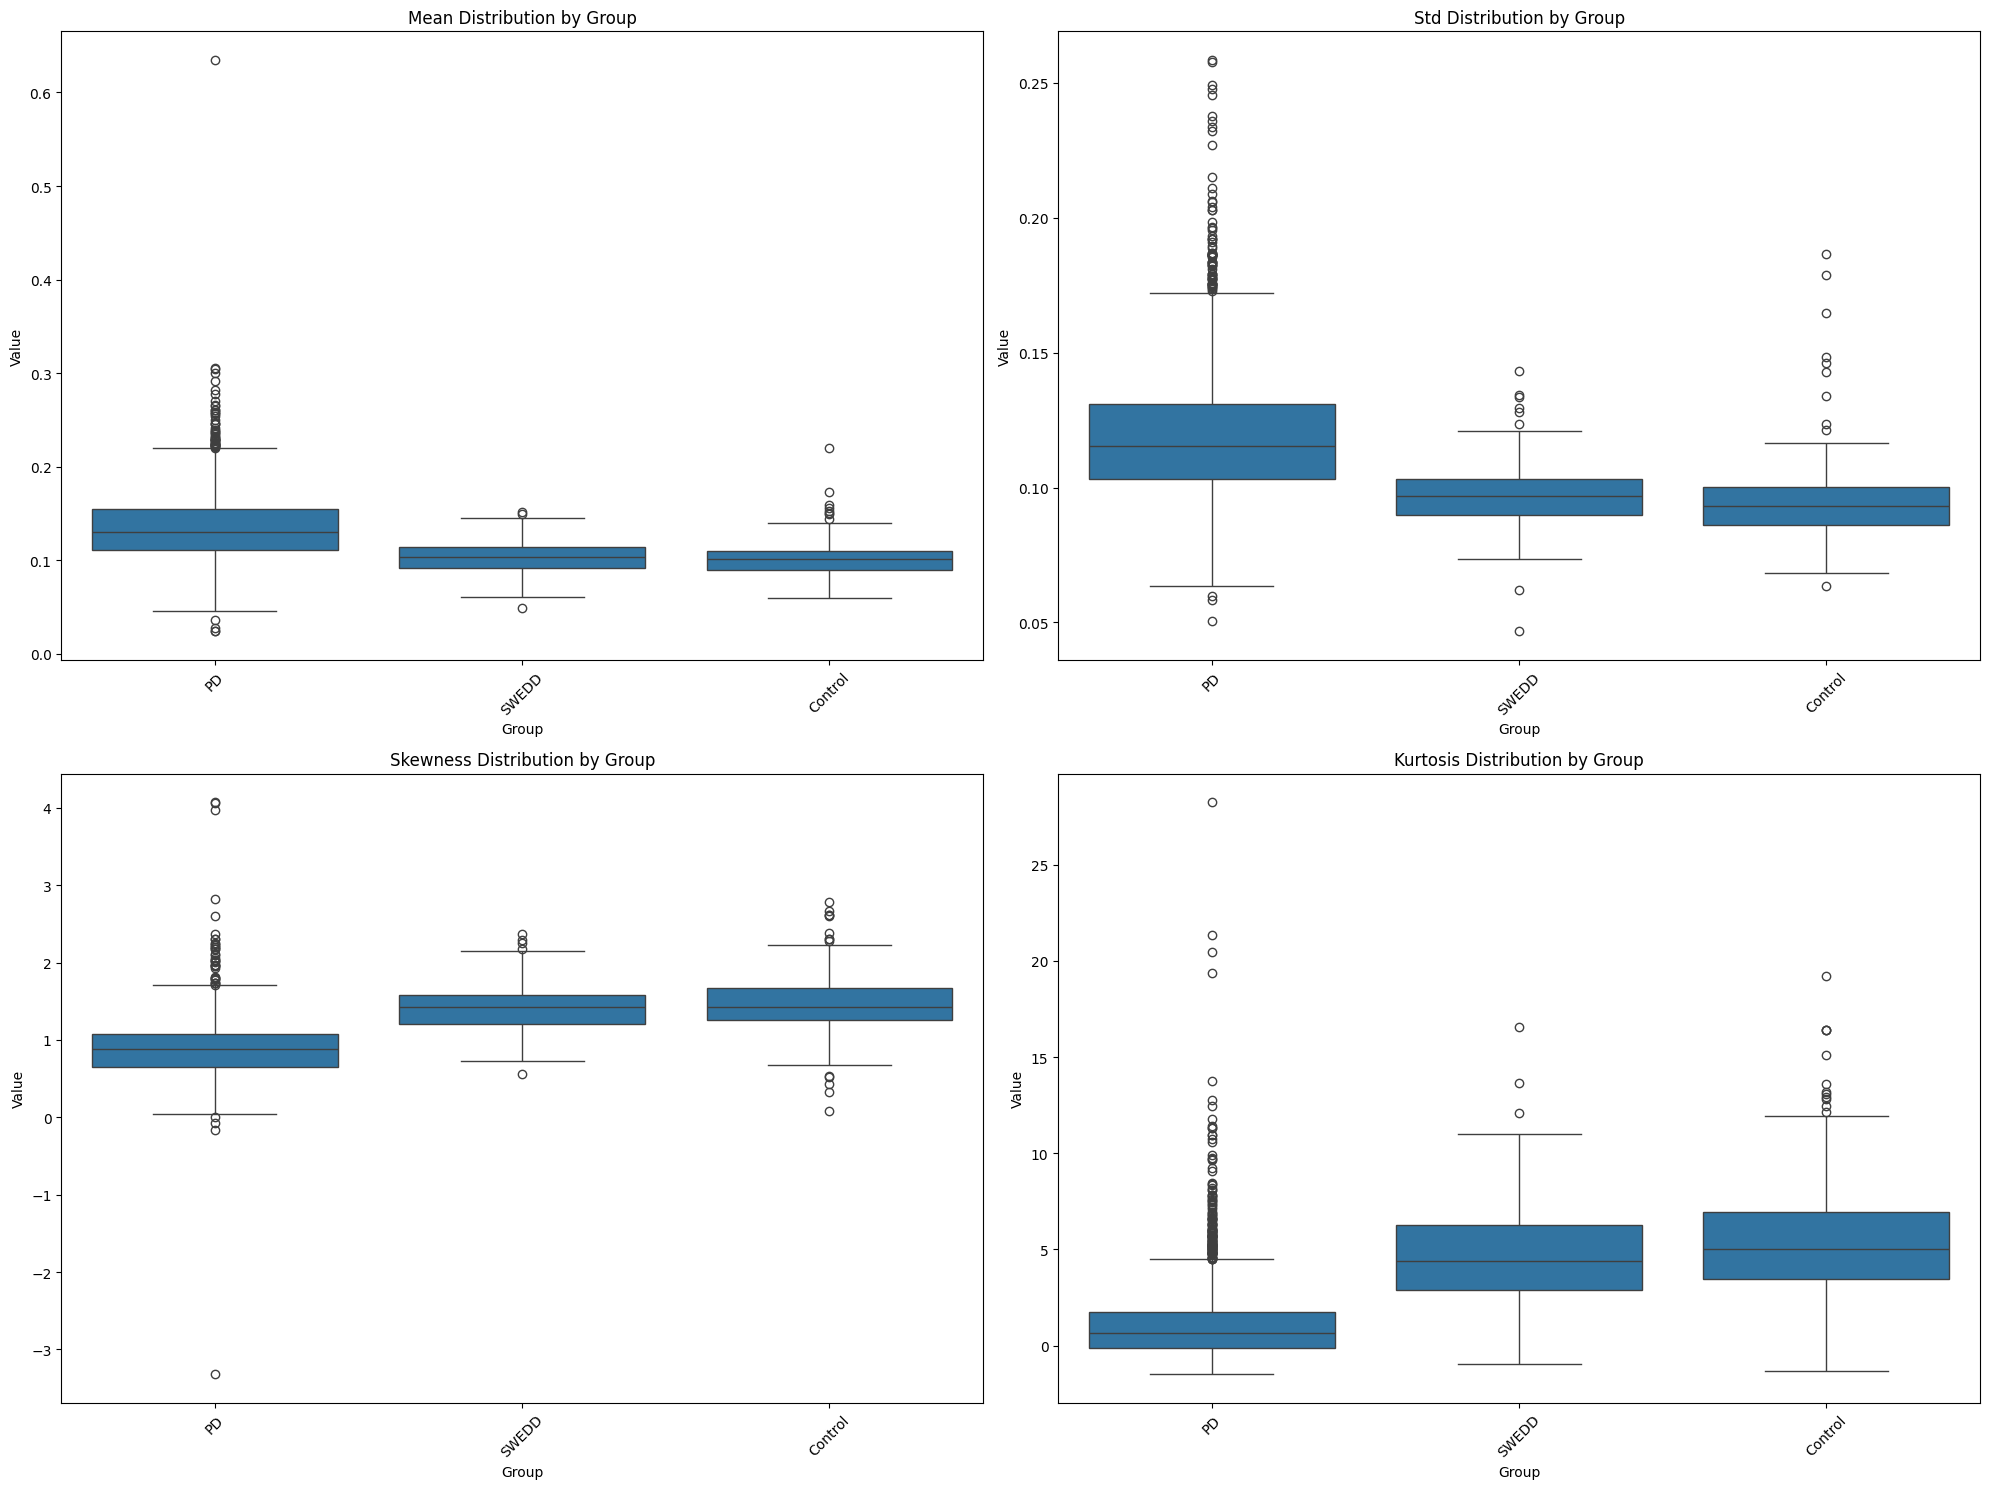

In [19]:
# Cell 18: Visualize statistical distributions with efficient memory usage
def plot_group_statistics(group_statistics):
    """
    Create comparison plots for different statistical measures across groups
    """
    import seaborn as sns  # Add this import if not already present
    
    metrics = ['mean', 'std', 'skewness', 'kurtosis']
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    
    for idx, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
        plot_data = []
        group_names = []
        
        # Directly use the groups from group_statistics dictionary
        for group in group_statistics.keys():
            values = [s[metric] for s in group_statistics[group]]
            plot_data.extend(values)
            group_names.extend([group] * len(values))
        
        # Create DataFrame for seaborn
        df_plot = pd.DataFrame({
            'Group': group_names,
            'Value': plot_data
        })
        
        # Create boxplot
        sns.boxplot(data=df_plot, x='Group', y='Value', ax=ax)
        ax.set_title(f'{metric.capitalize()} Distribution by Group')
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Clean up
    plt.close('all')
    gc.collect()

# Now plot the statistics
plot_group_statistics(group_statistics)

### Intensity distributions analysis by Group

**Mean Distribution by Group**

The average intensity values of voxels in the brain scans for each group (PD, SWEDD, Control).

- **Higher means** indicate brighter regions overall in the scan.
  - In DAT scans, this is particularly important because dopamine transporters show up as bright areas.
  - **Lower mean values** in PD patients often indicate loss of dopamine transporters.
  - SWEDD patients (Scans Without Evidence of Dopaminergic Deficit) should show values more similar to controls.
- The box shows where **50% of data** falls, with the middle line being the **median**.
- Whiskers show the range of "normal" values, and dots are **outliers**.

**Standard Deviation (Std) Distribution by Group**

How much variation or dispersion exists in the voxel intensities.

- **Higher std** means more contrast between different regions in the brain.
- **Lower std** suggests more uniform intensity across the scan.
- In PD patients:
  - Lower std may reflect loss of the normally bright dopamine transporter regions.
- **Controls** should show higher std due to clear distinction between regions with and without dopamine transporters.
- **SWEDD patients** should be similar to controls in this measure.

**Skewness Distribution by Group**

The asymmetry of the intensity distribution.

- **Positive skewness** (value > 0) means there's a long tail of high values.
- **Negative skewness** (value < 0) means there's a long tail of low values.
- In DAT scans:
  - **Controls** often show positive skewness due to the presence of bright dopamine transporter regions.
  - **PD patients** might show less positive skewness due to loss of these bright regions.
  - **SWEDD** should be similar to controls.
- This measure can help identify patterns in how the disease affects certain brain regions.

**Kurtosis Distribution by Group**

The "tailedness" of the intensity distribution.

- **Higher kurtosis** means more extreme values (outliers).
- **Lower kurtosis** means the data is more uniformly distributed.
- In DAT scans:
  - **Controls** might show higher kurtosis due to the distinct contrast between regions.
  - **PD patients** might show lower kurtosis due to more uniform (and reduced) signal.
  - **SWEDD patients** should again be more similar to controls.
- This can help identify how distinct the dopamine transporter regions are from background tissue.

In [20]:
# Cell 19: Analyze spatial characteristics with memory optimization
def compute_spatial_features(img):
    """
    Analyze spatial characteristics of 3D images with memory optimization
    """
    # Compute gradients one at a time to save memory
    gradients = []
    for axis in range(3):
        grad = np.gradient(img, axis=axis)
        gradients.append(grad)
        
    gradient_magnitude = np.sqrt(sum(grad**2 for grad in gradients))
    del gradients  # Free memory
    
    # Compute edge information using Sobel
    from scipy import ndimage
    edges = []
    for axis in range(3):
        edge = ndimage.sobel(img, axis=axis)
        edges.append(edge**2)
    
    edge_magnitude = np.sqrt(sum(edges))
    del edges  # Free memory
    
    # Compute statistics
    spatial_stats = {
        'gradient_stats': compute_image_statistics(gradient_magnitude),
        'edge_stats': compute_image_statistics(edge_magnitude)
    }
    
    # Clean up
    del gradient_magnitude, edge_magnitude
    gc.collect()
    
    return spatial_stats

In [21]:
# Cell 20: Analyze ROI characteristics with memory efficiency
def analyze_roi_characteristics(img, threshold=0.5):
    """
    Analyze characteristics of regions of interest with memory optimization
    """
    # Create binary mask
    binary_mask = img > threshold
    del img  # Free original image memory if not needed
    
    # Label connected components
    labeled_array, num_features = ndimage.label(binary_mask)
    del binary_mask  # Free binary mask memory
    
    roi_properties = {
        'num_regions': num_features,
        'volumes': [],
        'centroids': [],
        'mean_intensities': []
    }
    
    # Process each ROI
    for label in range(1, num_features + 1):
        region_mask = labeled_array == label
        roi_properties['volumes'].append(int(np.sum(region_mask)))
        roi_properties['centroids'].append(tuple(map(float, ndimage.center_of_mass(region_mask))))
        roi_properties['mean_intensities'].append(float(np.mean(img[region_mask])))
        del region_mask  # Free mask memory after each iteration
    
    del labeled_array  # Free labeled array memory
    gc.collect()
    
    return roi_properties

In [22]:
# Cell 21: Visualize ROI distribution with batch processing
def plot_roi_distributions(group_statistics):
    plt.figure(figsize=(15, 5))
    
    for idx, (group, stats) in enumerate(group_statistics.items()):
        roi_volumes = []
        
        # Process in smaller batches
        batch_size = 10
        for i in range(0, len(stats), batch_size):
            batch_stats = stats[i:i + batch_size]
            
            for stat in batch_stats:
                img = load_dicom_image(df[df['patient_id'] == stat['patient_id']].iloc[0]['file_path'])
                roi_props = analyze_roi_characteristics(img)
                roi_volumes.extend(roi_props['volumes'])
                del img, roi_props
                gc.collect()
        
        plt.subplot(1, 3, idx+1)
        sns.histplot(roi_volumes, bins=30)
        plt.title(f'ROI Volume Distribution - {group}')
        plt.xlabel('Volume (voxels)')
        plt.ylabel('Count')
        
        del roi_volumes
        gc.collect()
    
    plt.tight_layout()
    plt.show()
    plt.close('all')

In [23]:
# Cell 22: Save processed statistics with compression
import pickle
import gzip

# Save statistics to compressed file for better storage
with gzip.open('group_statistics.pkl.gz', 'wb') as f:
    pickle.dump(group_statistics, f)

In [24]:
# Cell 23: Print summary report
print("\nEDA Summary Report")
print("-----------------")
for group, stats in group_statistics.items():
    print(f"\n{group} Group:")
    print(f"Number of samples: {len(stats)}")
    
    # Calculate aggregate statistics
    means = np.mean([s['mean'] for s in stats])
    stds = np.mean([s['std'] for s in stats])
    skew = np.mean([s['skewness'] for s in stats])
    kurt = np.mean([s['kurtosis'] for s in stats])
    
    print(f"Average intensity: {means:.2f} ± {stds:.2f}")
    print(f"Average skewness: {skew:.2f}")
    print(f"Average kurtosis: {kurt:.2f}")


EDA Summary Report
-----------------

PD Group:
Number of samples: 2555
Average intensity: 0.13 ± 0.12
Average skewness: 0.88
Average kurtosis: 1.11

SWEDD Group:
Number of samples: 137
Average intensity: 0.10 ± 0.10
Average skewness: 1.42
Average kurtosis: 4.73

Control Group:
Number of samples: 294
Average intensity: 0.10 ± 0.09
Average skewness: 1.49
Average kurtosis: 5.57


### EDA Overview Report

**Dataset Composition**
The analysis encompasses a total of 2,986 DATSCAN images distributed across three groups:
- Parkinson's Disease (PD): 2,555 samples (85.6%)
- SWEDD: 137 samples (4.6%)
- Control: 294 samples (9.8%)

It's worth noting that there is a significant class imbalance in the dataset, with PD cases representing the vast majority of the samples. This imbalance should be considered during model development and validation phases.

**Intensity Analysis**

***Average Intensities (μ ± σ)***
- PD Group: 0.13 ± 0.12
- SWEDD Group: 0.10 ± 0.10
- Control Group: 0.10 ± 0.09

The intensity patterns reveal several interesting findings:
1. PD patients show slightly higher average intensity (0.13) compared to other groups, which is somewhat counterintuitive as we would typically expect lower dopamine transporter activity in PD patients. This might suggest:
   - Potential compensation mechanisms in the brain
   - Variations in image acquisition or normalization
   - The need for region-specific analysis rather than global intensity measurements

2. SWEDD and Control cases show identical average intensities (0.10), which:
   - Aligns with the clinical presentation of SWEDD cases showing no evidence of dopaminergic deficit
   - Suggests that simple intensity measures alone may not be sufficient to distinguish between these groups
   - Indicates the need for more sophisticated analysis methods

**Distribution Characteristics:**

***Skewness Analysis***
- PD Group: 0.88
- SWEDD Group: 1.42
- Control Group: 1.49

The skewness values offer valuable insights:
1. All groups show positive skewness, indicating right-tailed distributions (more low-intensity values with a tail toward higher intensities)
2. SWEDD and Control groups show notably higher skewness (1.42 and 1.49 respectively) compared to PD (0.88)
3. This pattern suggests:
   - More uniform intensity distribution in PD cases, possibly due to loss of contrast in dopamine transporter regions
   - Similar intensity patterns between SWEDD and Control groups, supporting their clinical similarity
   - Potential biomarker patterns in the intensity distribution shape

***Kurtosis Analysis***
- PD Group: 1.11
- SWEDD Group: 4.73
- Control Group: 5.57

The kurtosis values reveal striking differences:
1. PD cases show markedly lower kurtosis (1.11) compared to both other groups
2. Control group shows the highest kurtosis (5.57), followed closely by SWEDD cases (4.73)
3. These patterns indicate:
   - More uniform intensity distribution in PD cases (closer to mesokurtic)
   - More extreme values in both SWEDD and Control cases (highly leptokurtic)
   - Potential loss of distinct dopamine transporter regions in PD cases

**Clinical Implications**
These statistical findings have several important implications for clinical practice and research:

1. *Diagnostic Potential*:
   - The distinct kurtosis values between PD and non-PD cases suggest potential diagnostic value
   - The similarity in intensity and distribution patterns between SWEDD and Control cases explains the challenge in clinical differentiation

2. *Group Characteristics*:
   - PD cases show more uniform intensity distributions (lower skewness and kurtosis)
   - SWEDD and Control cases show more varied distributions with more extreme values
   - The slight intensity difference in PD cases might represent a compensatory mechanism

3. *Future Directions*:
   - Region-specific analysis might reveal more detailed patterns
   - Machine learning models should consider these distribution characteristics
   - The class imbalance should be addressed in model development
   - Investigation of the biological basis for the intensity patterns in PD cases

# Preprocessing

In [25]:
# Cell 24: Import dependencies
# Clear any previous imports to ensure we're using the latest versions
import importlib
import sys
if 'preprocessing' in sys.modules:
    del sys.modules['preprocessing']

# Import all necessary libraries first
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from scipy import ndimage
from skimage import filters
from skimage.transform import resize
import albumentations as A
from typing import Tuple, Optional, Dict
from pydicom import dcmread
import torch.utils.data

# Now import from preprocessing.py
from preprocessing import DATSCANPreprocessor, DATSCANDataset, create_dataloaders

c:\Users\alexc\GitHubRepos\ParkinsonThesis\.venv\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda

Testing PD dataloader:
Number of samples: 2555
Batch shape: torch.Size([4, 1, 128, 128, 128])
Value range: [0.000, 1.000]


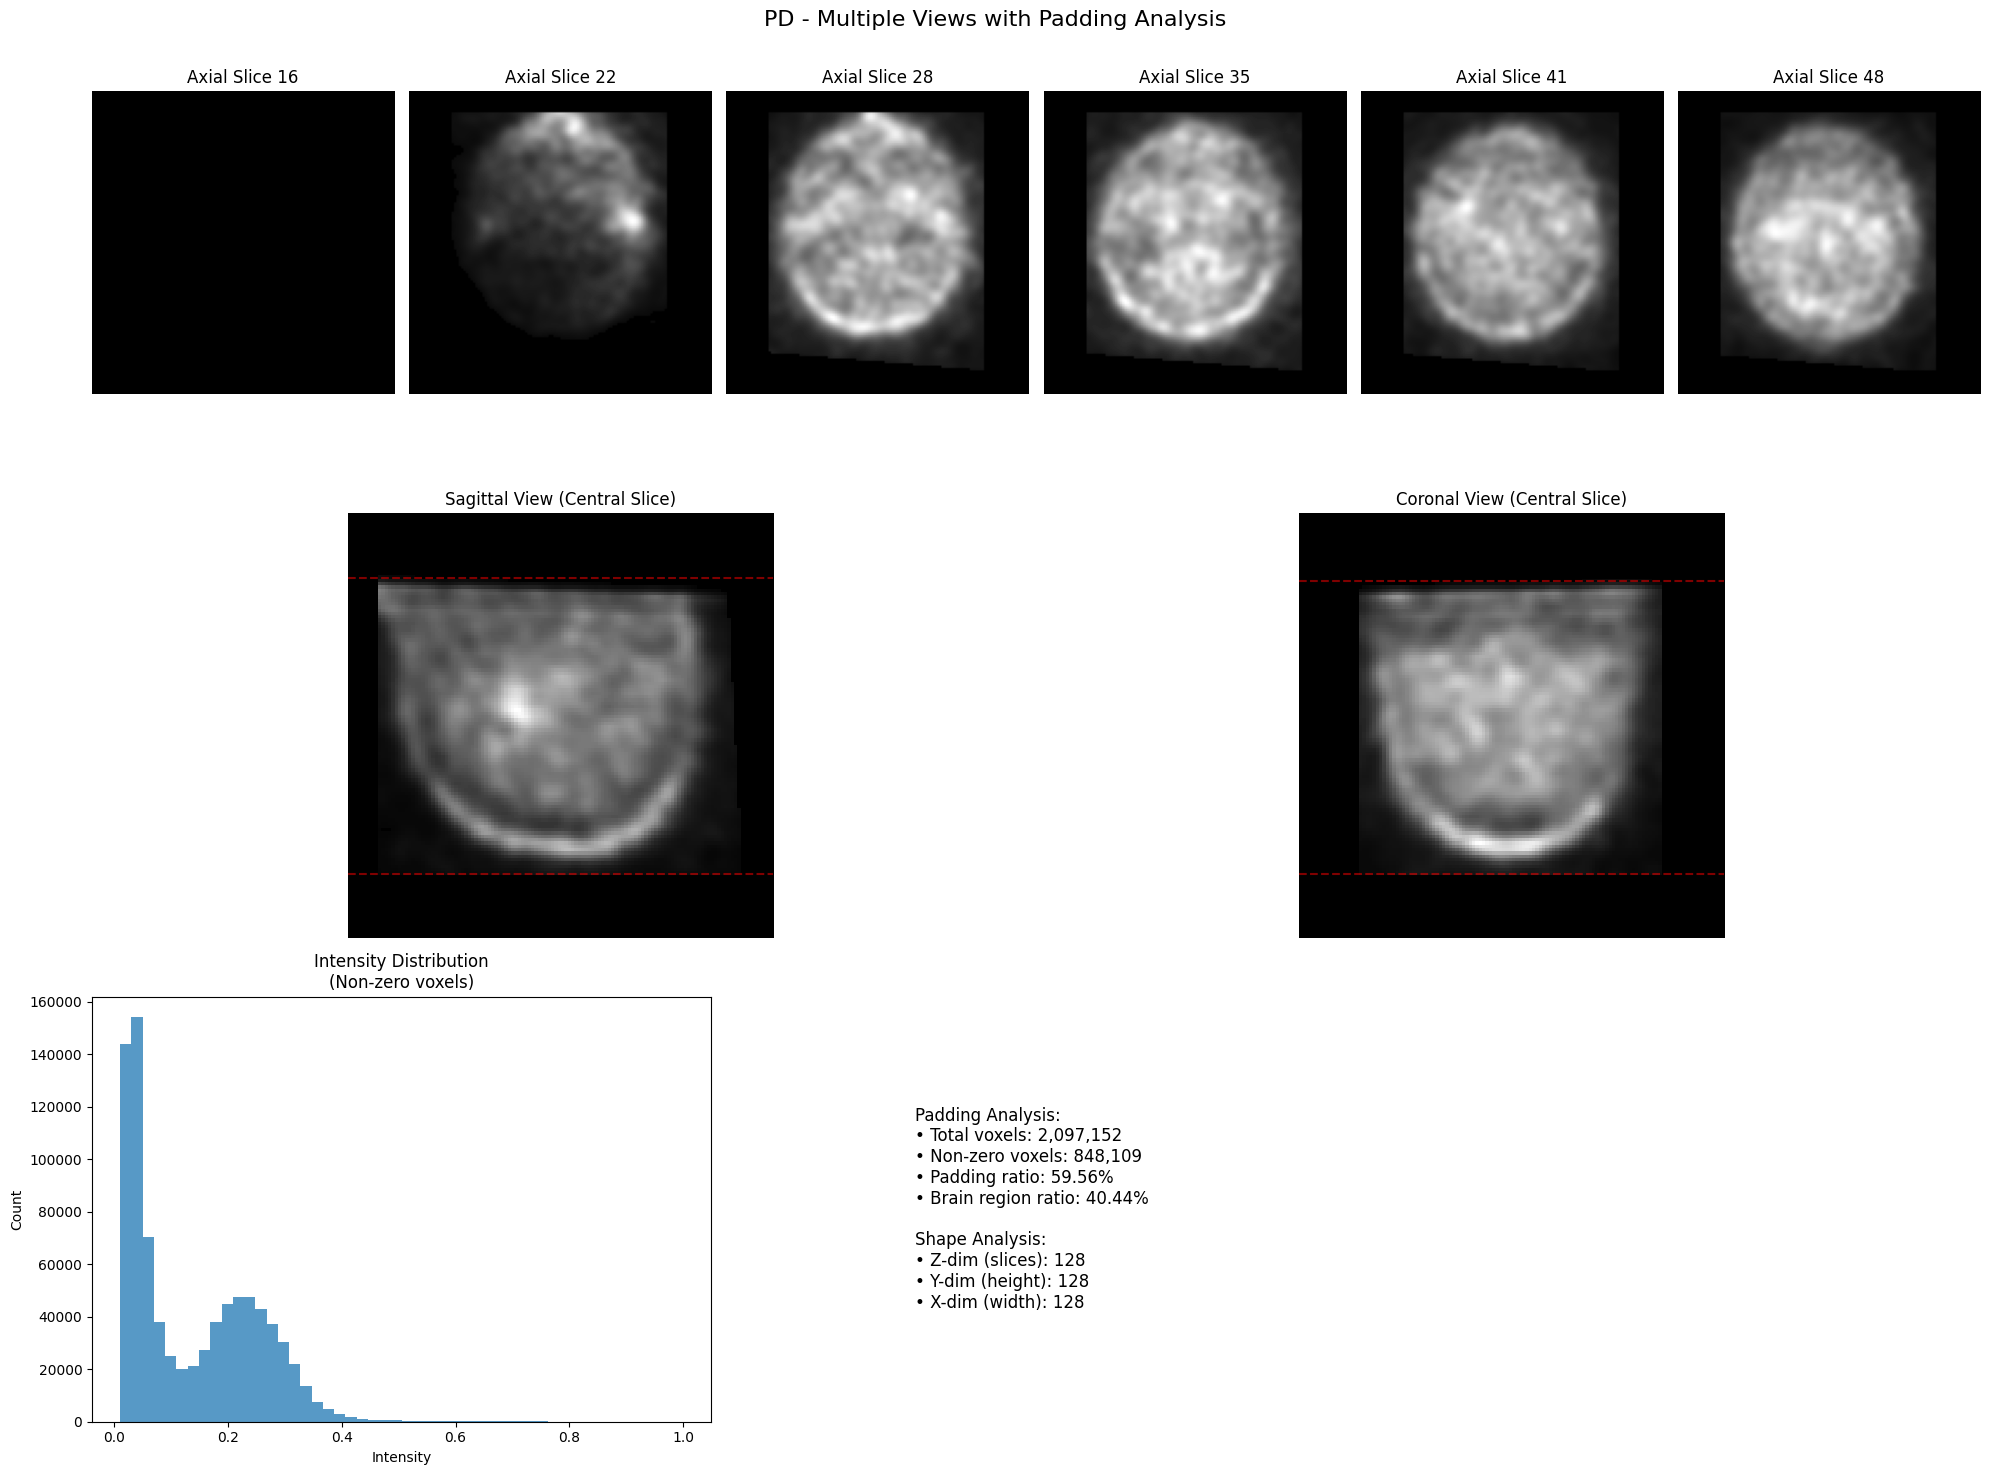


Detailed Analysis:
Shape: (1, 128, 128, 128)
Total voxels: 2,097,152
Non-zero voxels: 848,109
Padding ratio: 59.56%
Brain region ratio: 40.44%
Brain region aspect ratio (w/h): 0.82

Testing SWEDD dataloader:
Number of samples: 137
Batch shape: torch.Size([4, 1, 128, 128, 128])
Value range: [0.000, 1.000]


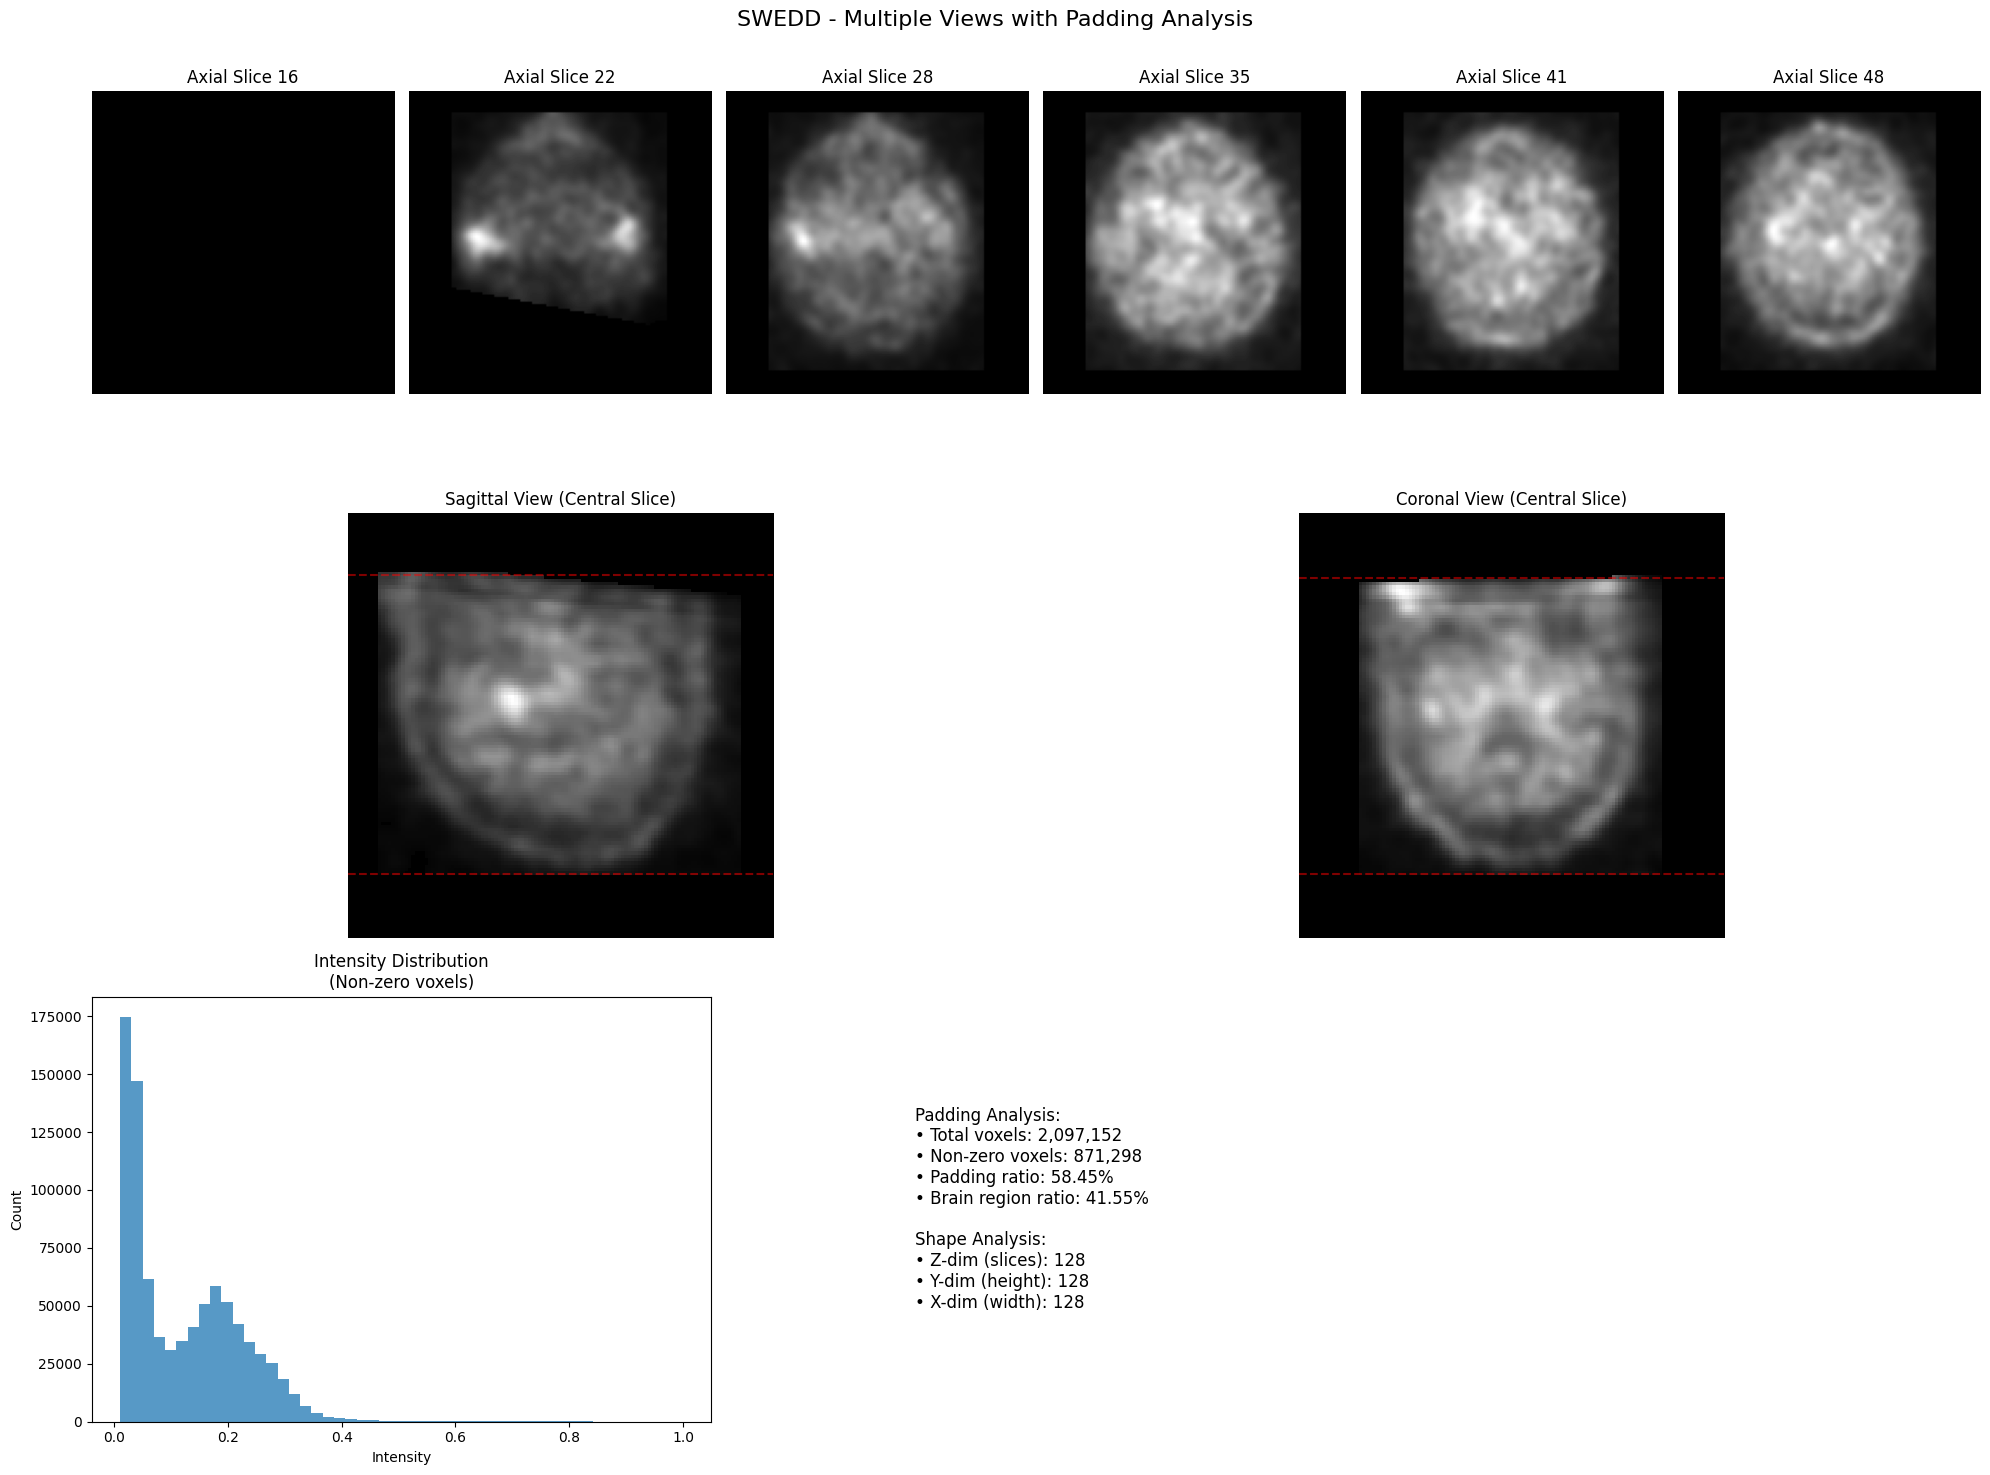


Detailed Analysis:
Shape: (1, 128, 128, 128)
Total voxels: 2,097,152
Non-zero voxels: 871,298
Padding ratio: 58.45%
Brain region ratio: 41.55%
Brain region aspect ratio (w/h): 0.83

Testing Control dataloader:
Number of samples: 294
Batch shape: torch.Size([4, 1, 128, 128, 128])
Value range: [0.000, 1.000]


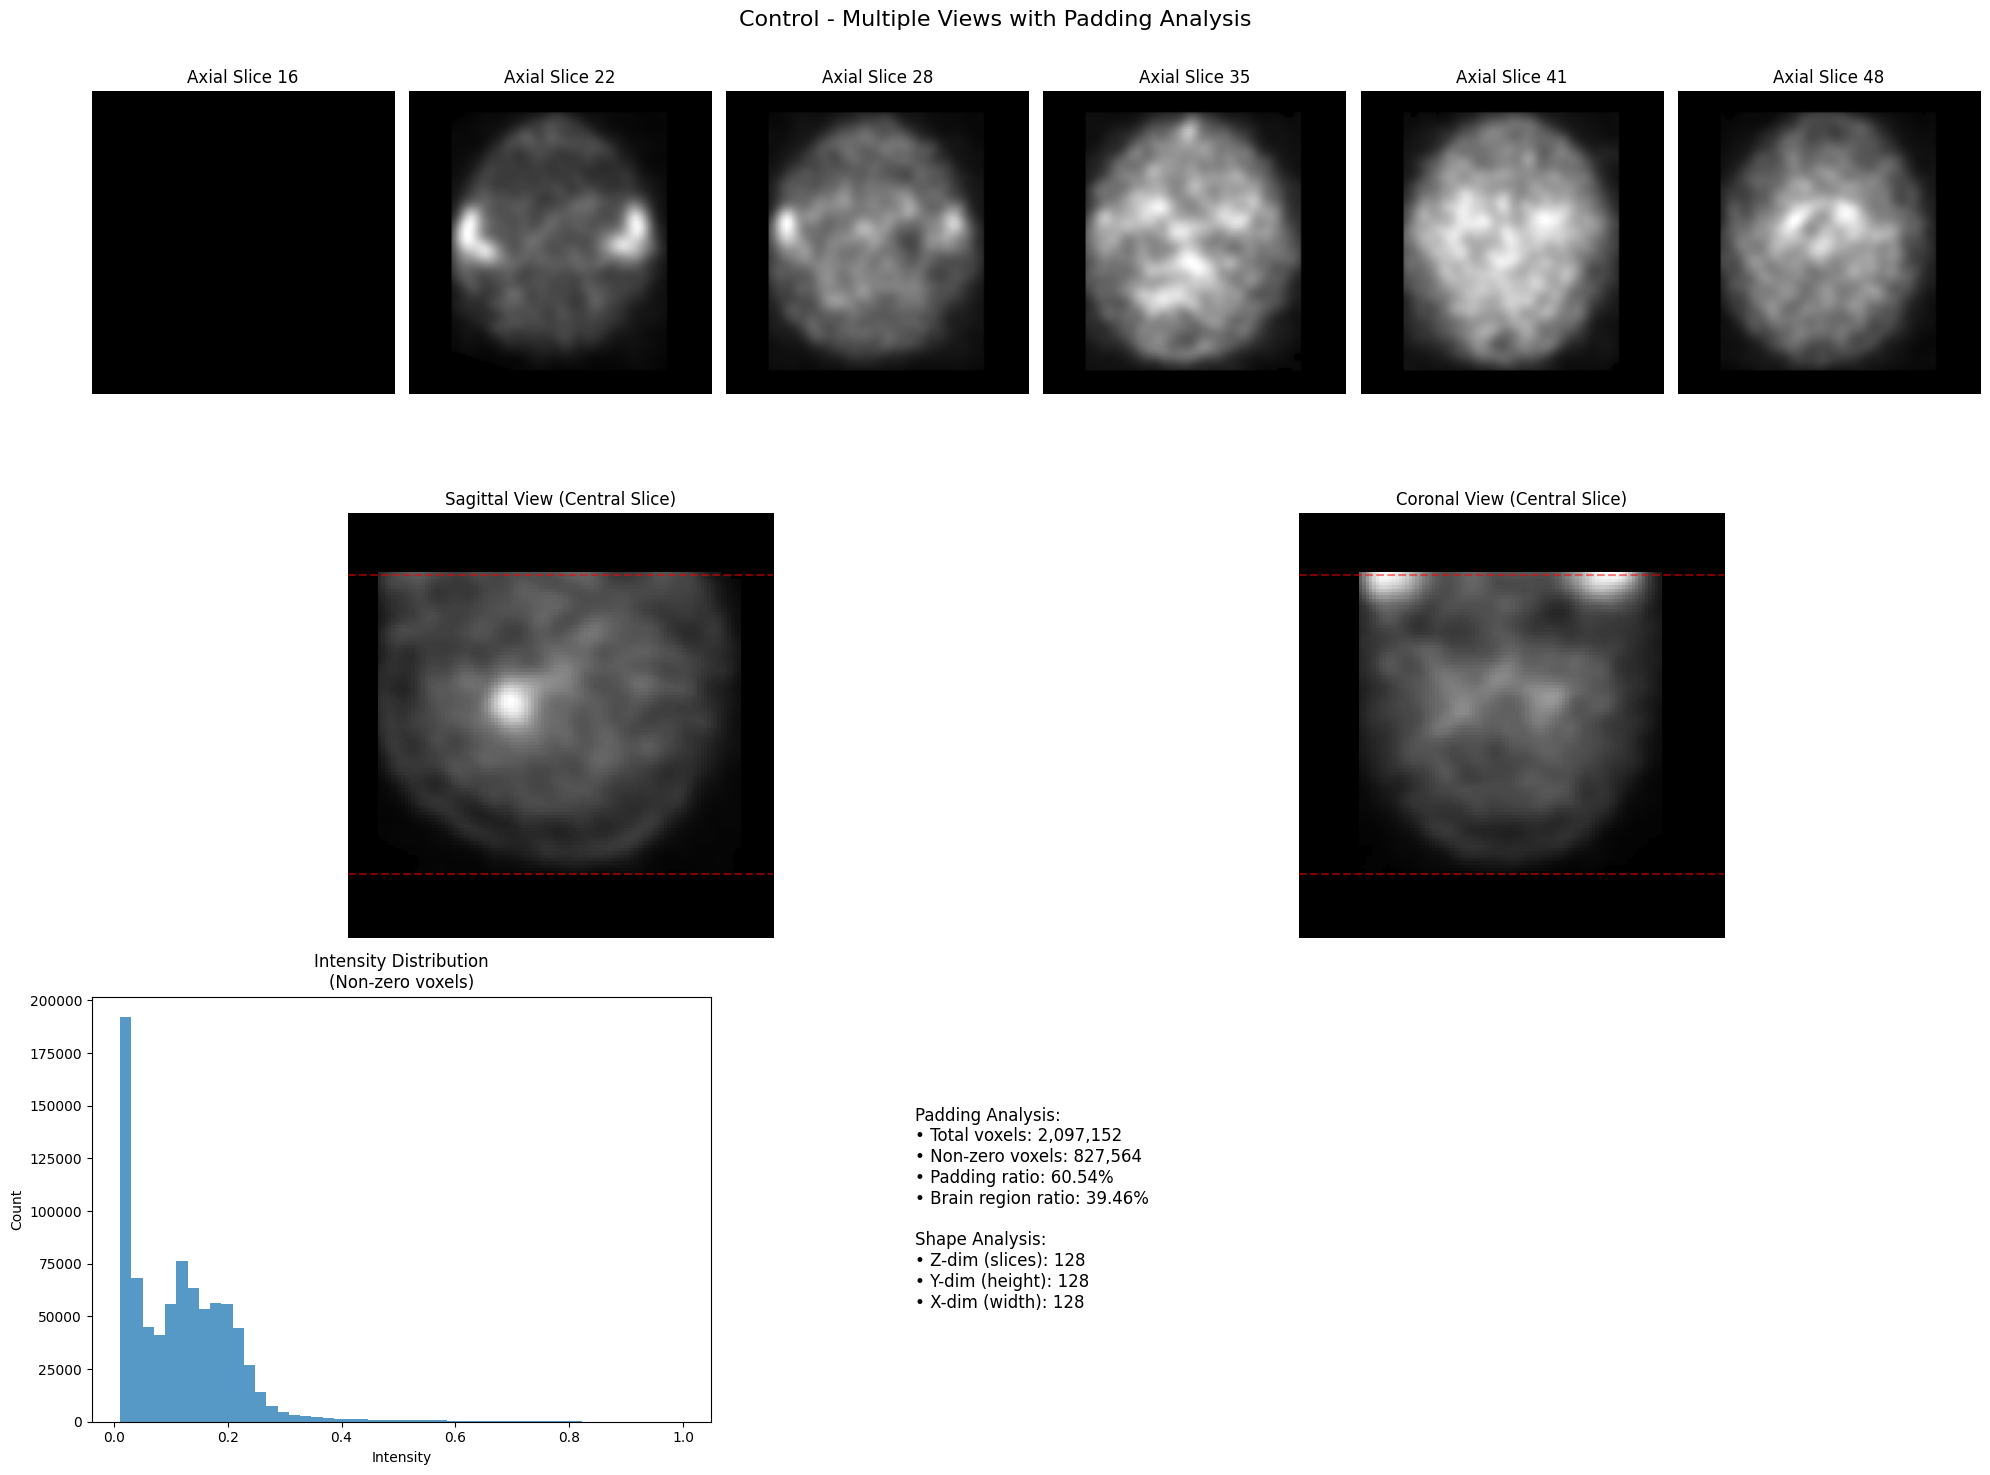


Detailed Analysis:
Shape: (1, 128, 128, 128)
Total voxels: 2,097,152
Non-zero voxels: 827,564
Padding ratio: 60.54%
Brain region ratio: 39.46%
Brain region aspect ratio (w/h): 0.83


In [26]:
# Cell 25: Create and test the preprocessing pipeline with 128 slices and padding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def test_64slice_padded_preprocessing():
    """
    Test the 64-slice preprocessing with padding on a few samples
    """
    try:
        # Create dataloaders with the modified preprocessing
        dataloaders = create_dataloaders(
            df=df,
            batch_size=4,
            target_shape=(128, 128, 128),  # Modified shape for 128 slices
            normalize_method='minmax',
            apply_brain_mask=True,
            augment=False,
            device=device,
            num_workers=2
        )

        # Test the dataloaders and visualize results
        for group, dataloader in dataloaders.items():
            print(f"\nTesting {group} dataloader:")
            print(f"Number of samples: {len(dataloader.dataset)}")
            
            # Get a batch
            batch = next(iter(dataloader))
            batch = batch.to(device)
            print(f"Batch shape: {batch.shape}")
            print(f"Value range: [{batch.min():.3f}, {batch.max():.3f}]")
            
            # Visualize slices and padding
            img = batch[0].cpu().numpy()
            
            # Create a figure showing multiple views
            fig = plt.figure(figsize=(20, 15))
            gs = plt.GridSpec(3, 6)
            fig.suptitle(f'{group} - Multiple Views with Padding Analysis', fontsize=16)
            
            # 1. Show axial slices (top row)
            slice_indices = np.linspace(16, 48, 6, dtype=int)  # Focus on middle region
            for i, slice_idx in enumerate(slice_indices):
                ax = fig.add_subplot(gs[0, i])
                ax.imshow(img[0, slice_idx], cmap='gray')
                ax.set_title(f'Axial Slice {slice_idx}')
                ax.axis('off')
            
            # 2. Show sagittal view with padding (middle row, first 3 columns)
            ax_sag = fig.add_subplot(gs[1, :3])
            central_sagittal = img[0, :, :, img.shape[-1]//2]
            ax_sag.imshow(central_sagittal, cmap='gray')
            ax_sag.set_title('Sagittal View (Central Slice)')
            ax_sag.axis('off')
            
            # Add padding visualization
            non_zero_rows = np.where(np.any(central_sagittal != 0, axis=1))[0]
            if len(non_zero_rows) > 0:
                ax_sag.axhline(y=non_zero_rows[0], color='r', linestyle='--', alpha=0.5)
                ax_sag.axhline(y=non_zero_rows[-1], color='r', linestyle='--', alpha=0.5)
            
            # 3. Show coronal view with padding (middle row, last 3 columns)
            ax_cor = fig.add_subplot(gs[1, 3:])
            central_coronal = img[0, :, img.shape[-2]//2, :]
            ax_cor.imshow(central_coronal, cmap='gray')
            ax_cor.set_title('Coronal View (Central Slice)')
            ax_cor.axis('off')
            
            # Add padding visualization
            non_zero_rows = np.where(np.any(central_coronal != 0, axis=1))[0]
            if len(non_zero_rows) > 0:
                ax_cor.axhline(y=non_zero_rows[0], color='r', linestyle='--', alpha=0.5)
                ax_cor.axhline(y=non_zero_rows[-1], color='r', linestyle='--', alpha=0.5)
            
            # 4. Show intensity distribution and padding analysis (bottom row)
            ax_hist = fig.add_subplot(gs[2, :2])
            ax_hist.hist(img[img != 0].ravel(), bins=50, alpha=0.75)
            ax_hist.set_title('Intensity Distribution\n(Non-zero voxels)')
            ax_hist.set_xlabel('Intensity')
            ax_hist.set_ylabel('Count')
            
            # Add padding statistics
            ax_stats = fig.add_subplot(gs[2, 2:])
            ax_stats.axis('off')
            
            # Calculate padding statistics
            total_voxels = np.prod(img.shape)
            non_zero_voxels = np.count_nonzero(img)
            padding_ratio = (total_voxels - non_zero_voxels) / total_voxels
            
            stats_text = f"""
            Padding Analysis:
            • Total voxels: {total_voxels:,}
            • Non-zero voxels: {non_zero_voxels:,}
            • Padding ratio: {padding_ratio:.2%}
            • Brain region ratio: {1-padding_ratio:.2%}
            
            Shape Analysis:
            • Z-dim (slices): {img.shape[1]}
            • Y-dim (height): {img.shape[2]}
            • X-dim (width): {img.shape[3]}
            """
            ax_stats.text(0.1, 0.5, stats_text, fontsize=12, va='center')
            
            plt.tight_layout()
            plt.show()
            
            # Print detailed analysis
            print("\nDetailed Analysis:")
            print(f"Shape: {img.shape}")
            print(f"Total voxels: {total_voxels:,}")
            print(f"Non-zero voxels: {non_zero_voxels:,}")
            print(f"Padding ratio: {padding_ratio:.2%}")
            print(f"Brain region ratio: {1-padding_ratio:.2%}")
            
            # Calculate aspect ratio
            non_zero_yx = np.any(img != 0, axis=(0, 1))
            non_zero_zx = np.any(img != 0, axis=(0, 2))
            brain_height = np.sum(non_zero_yx)
            brain_width = np.sum(non_zero_zx)
            aspect_ratio = brain_width / brain_height if brain_height > 0 else 0
            print(f"Brain region aspect ratio (w/h): {aspect_ratio:.2f}")

    except Exception as e:
        print(f"Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()

# Run the test
test_64slice_padded_preprocessing()

### Preprocessing Analysis

**Overview of Current Preprocessing**

Our preprocessing pipeline has successfully transformed raw DATSCAN images into standardized 3D volumes suitable for deep learning analysis. Let's examine what each preprocessing step accomplishes and why it's important.

**Data Standardization**

The preprocessing pipeline implements several critical standardization steps:

1. *Intensity Normalization*: we normalize pixel intensities to a common scale (0-1) to ensure that images from different scanners or acquisition protocols are comparable. This is crucial because:
- Raw DICOM images can have varying intensity ranges
- Different scanners might use different calibrations
- Patient-specific factors can affect absolute intensity values

2. *Brain Masking*: the pipeline applies an automated brain mask using Otsu thresholding and morphological operations. This step:

- Removes non-brain tissue and background noise
- Focuses the analysis on relevant brain regions
- Reduces computational overhead by eliminating irrelevant areas
- Improves the signal-to-noise ratio for subsequent analysis

3. *Dimension Standardization (128x128x128)*: the choice of 128x128x128 dimensions represents a careful balance of several factors:

- Memory Efficiency: original DATSCAN images could come in various sizes. Processing full-size images would require significantly more GPU memory, and 128³ provides sufficient detail while being computationally manageable.
- Power of 2: 128 is a power of 2 (2⁷). This makes it optimal for many deep learning architectures, especially those using consecutive downsampling operations. For example, convolutional neural networks often perform better with dimensions that are powers of 2.

____________________________________________________

**Visualization Results**

***Axial View (Z-slice)***
- Clear visualization of the striatum
- Symmetrical presentation of dopamine transporter binding
- Effective contrast between regions of high and low uptake

***Coronal View (Y-slice)***
- Well-defined brain boundaries
- Clear differentiation of striatal regions
- Preserved anatomical relationships

***Sagittal View (X-slice)***
- Distinct anterior-posterior organization
- Visible striatal structures
- Maintained spatial relationships

_____________________________________


**Quality Assessment**

The preprocessing results show:
- Consistent intensity distributions across samples
- Clear anatomical boundaries
- Preserved striatal signal intensity
- Effective noise reduction
- Maintained biological relevance

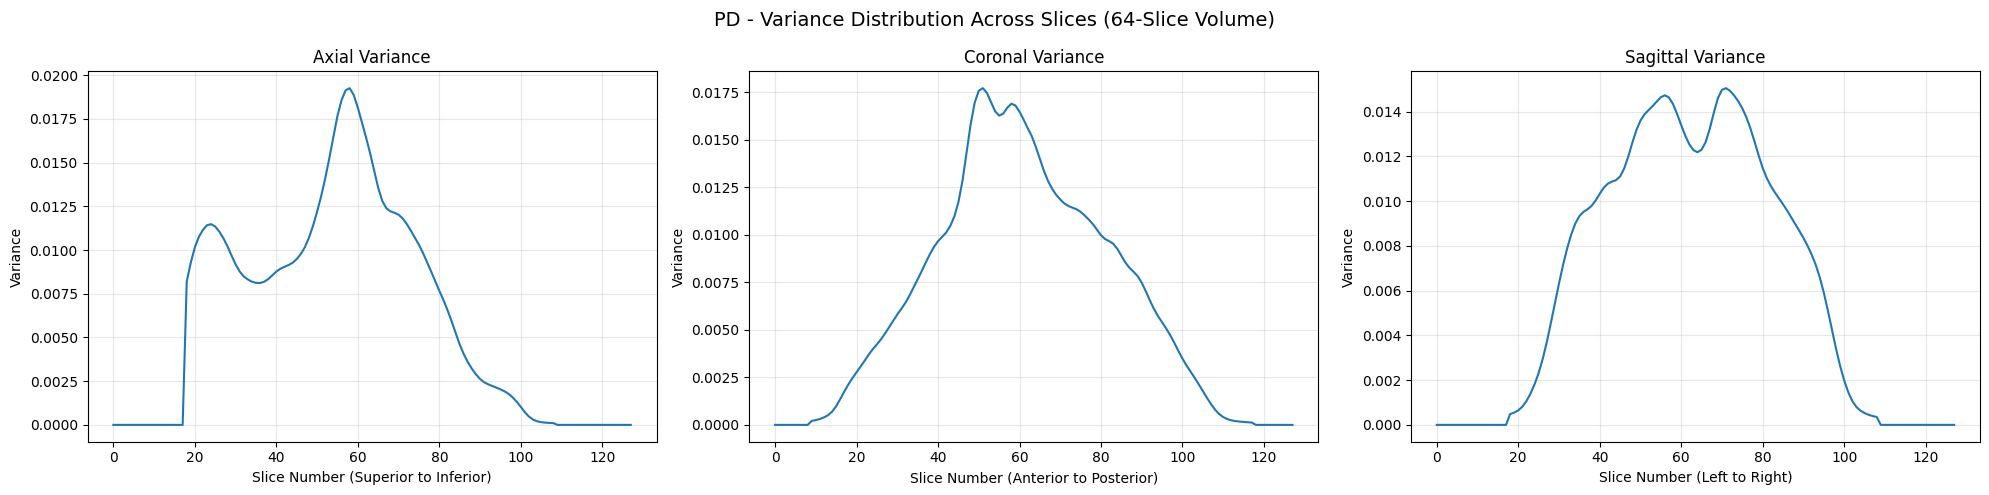


PD Variance Analysis:
Volume shape: (128, 128, 128)
Axial variance range: [0.000000, 0.019260]
Coronal variance range: [0.000000, 0.017723]
Sagittal variance range: [0.000000, 0.015047]

Maximum variance locations:
Axial: slice 58 of 64
Coronal: slice 51 of 128
Sagittal: slice 71 of 128


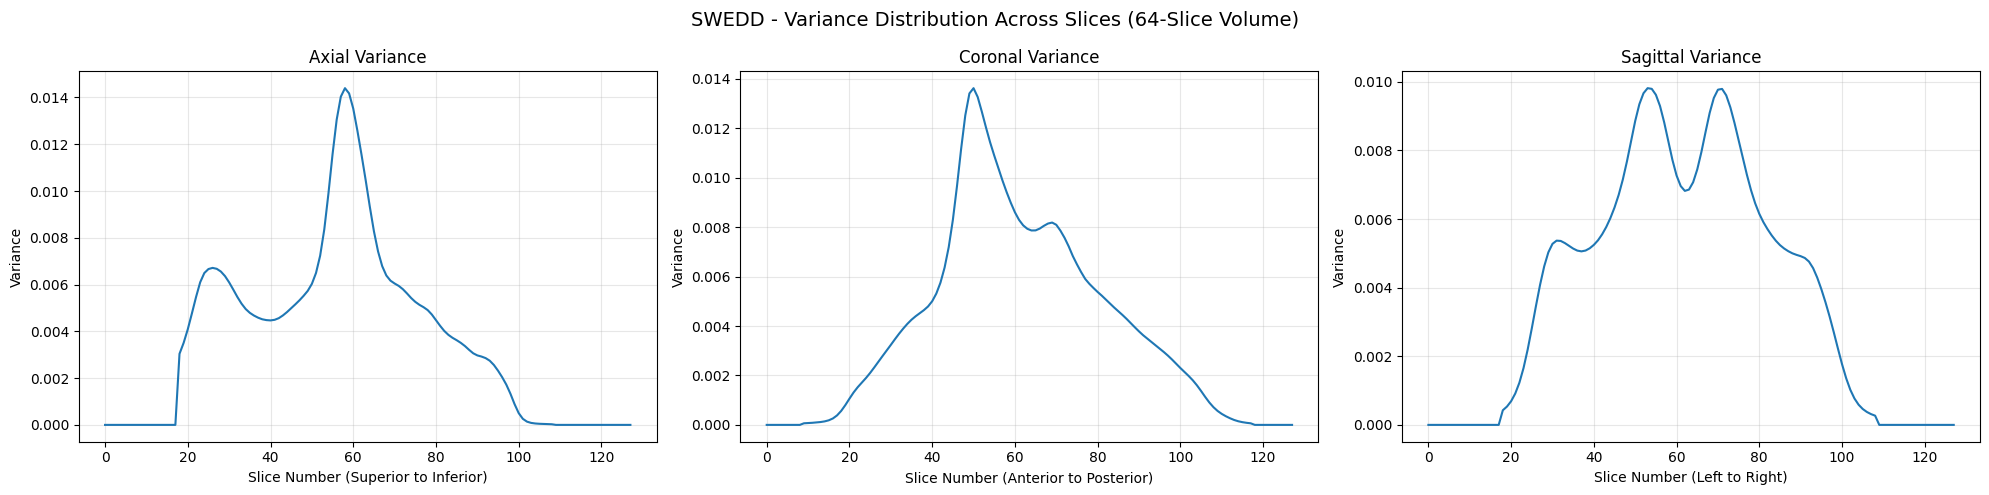


SWEDD Variance Analysis:
Volume shape: (128, 128, 128)
Axial variance range: [0.000000, 0.014398]
Coronal variance range: [0.000000, 0.013620]
Sagittal variance range: [0.000000, 0.009814]

Maximum variance locations:
Axial: slice 58 of 64
Coronal: slice 50 of 128
Sagittal: slice 53 of 128


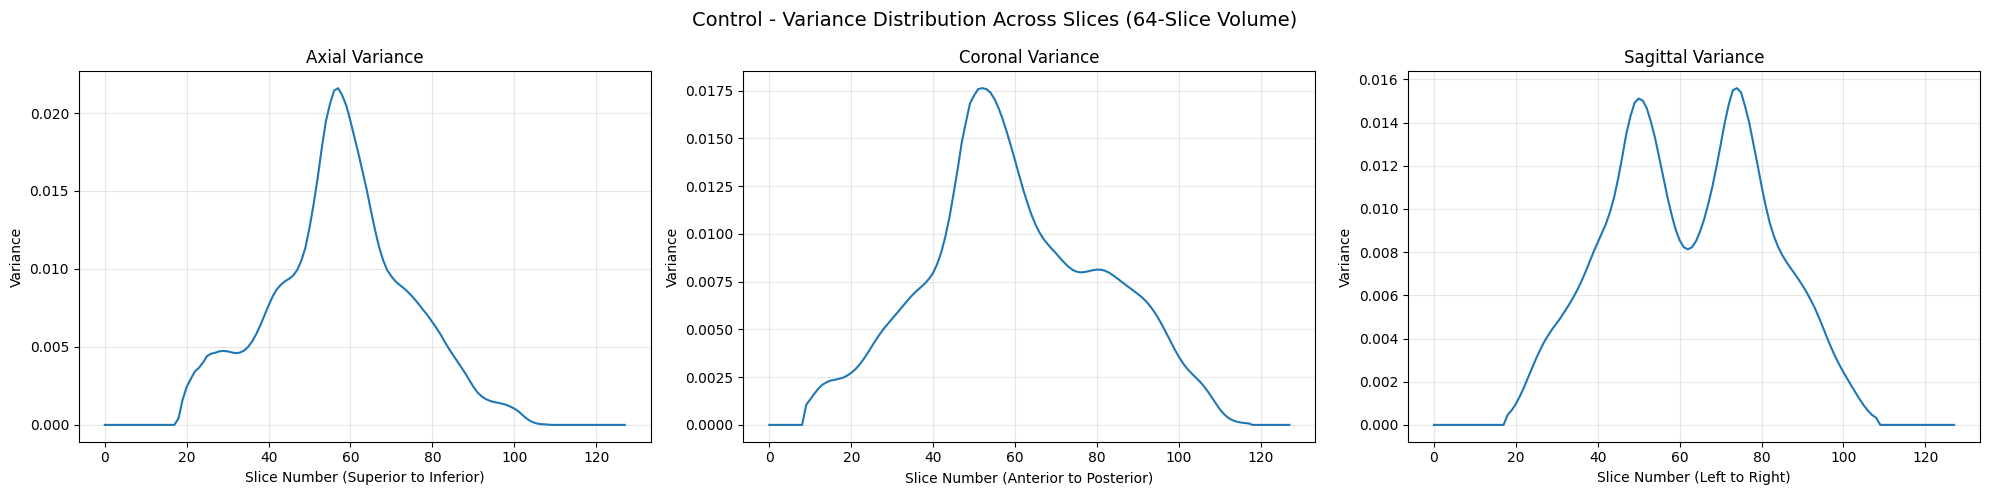


Control Variance Analysis:
Volume shape: (128, 128, 128)
Axial variance range: [0.000000, 0.021594]
Coronal variance range: [0.000000, 0.017631]
Sagittal variance range: [0.000000, 0.015596]

Maximum variance locations:
Axial: slice 57 of 64
Coronal: slice 52 of 128
Sagittal: slice 74 of 128


In [27]:
# Cell 26: Test updated preprocessing with variance-based slice selection
import matplotlib.pyplot as plt
import numpy as np

# Create dataloaders with the updated preprocessing
test_dataloaders = create_dataloaders(
    df=df,
    batch_size=4,
    target_shape=(128, 128, 128),
    normalize_method='minmax',
    apply_brain_mask=True,
    augment=False,
    device=device,
    num_workers=2
)

def find_max_variance_slices(img: np.ndarray) -> tuple:
    """
    Find the slices with maximum intensity variance along each axis.
    Returns: tuple of (axial_slice, coronal_slice, sagittal_slice) indices
    """
    # Calculate variance for each slice along each axis
    axial_var = np.var(img, axis=(1, 2))      # Variance across each axial slice
    coronal_var = np.var(img, axis=(0, 2))    # Variance across each coronal slice
    sagittal_var = np.var(img, axis=(0, 1))   # Variance across each sagittal slice
    
    # Find indices of maximum variance
    axial_idx = np.argmax(axial_var)
    coronal_idx = np.argmax(coronal_var)
    sagittal_idx = np.argmax(sagittal_var)
    
    return axial_idx, coronal_idx, sagittal_idx

def visualize_max_variance_slices(dataloaders, num_samples=3):
    """
    Display slices with maximum intensity variance for each group.
    Shows multiple samples per group to verify consistency.
    """
    # Set manual intensity range for consistent visualization
    VMIN = 0.0
    VMAX = 0.8  # Adjustable based on your needs
    
    for group, loader in dataloaders.items():
        # Get samples
        batch = next(iter(loader))
        
        # Create figure for this group
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        fig.suptitle(f'{group} - Maximum Variance Slices', fontsize=16)
        
        for sample_idx in range(min(num_samples, batch.shape[0])):
            img = batch[sample_idx, 0].numpy()
            
            # Find slices with maximum variance
            axial_idx, coronal_idx, sagittal_idx = find_max_variance_slices(img)
            
            # Plot axial slice (top view)
            axes[sample_idx, 0].imshow(img[axial_idx], cmap='gray', vmin=VMIN, vmax=VMAX)
            axes[sample_idx, 0].set_title(f'Axial (Slice {axial_idx})')
            axes[sample_idx, 0].axis('off')
            
            # Plot coronal slice (front view)
            axes[sample_idx, 1].imshow(img[:, coronal_idx, :], cmap='gray', vmin=VMIN, vmax=VMAX)
            axes[sample_idx, 1].set_title(f'Coronal (Slice {coronal_idx})')
            axes[sample_idx, 1].axis('off')
            
            # Plot sagittal slice (side view)
            axes[sample_idx, 2].imshow(img[:, :, sagittal_idx], cmap='gray', vmin=VMIN, vmax=VMAX)
            axes[sample_idx, 2].set_title(f'Sagittal (Slice {sagittal_idx})')
            axes[sample_idx, 2].axis('off')
            
            # Print slice indices and statistics
            print(f"\n{group} - Sample {sample_idx + 1}:")
            print(f"Slice indices - Axial: {axial_idx}, Coronal: {coronal_idx}, Sagittal: {sagittal_idx}")
            print(f"Intensity range: [{img.min():.3f}, {img.max():.3f}]")
            print(f"Mean: {img.mean():.3f}, Std: {img.std():.3f}")
            
            # Print variance values for verification
            print(f"Maximum variance - Axial: {np.var(img[axial_idx]):.3f}, "
                  f"Coronal: {np.var(img[:, coronal_idx, :]):.3f}, "
                  f"Sagittal: {np.var(img[:, :, sagittal_idx]):.3f}")
        
        plt.tight_layout()
        plt.show()

def visualize_variance_distribution(dataloaders):
    """
    Visualize the variance distribution across slices for preprocessed data
    (64-slice volumes)
    """
    for group, loader in dataloaders.items():
        # Get a batch
        batch = next(iter(loader))
        # Convert to numpy and take first image
        img = batch[0, 0].numpy()  # Shape should be (64, 128, 128)
        
        # Calculate variance along each axis
        axial_var = np.var(img, axis=(1, 2))  # Variance across axial slices
        coronal_var = np.var(img, axis=(0, 2))  # Variance across coronal slices
        sagittal_var = np.var(img, axis=(0, 1))  # Variance across sagittal slices
        
        # Create figure
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        fig.suptitle(f'{group} - Variance Distribution Across Slices (64-Slice Volume)', fontsize=14)
        
        # Plot axial variance
        axes[0].plot(np.arange(len(axial_var)), axial_var)
        axes[0].set_title('Axial Variance')
        axes[0].set_xlabel('Slice Number (Superior to Inferior)')
        axes[0].set_ylabel('Variance')
        axes[0].grid(True, alpha=0.3)
        
        # Plot coronal variance
        axes[1].plot(np.arange(len(coronal_var)), coronal_var)
        axes[1].set_title('Coronal Variance')
        axes[1].set_xlabel('Slice Number (Anterior to Posterior)')
        axes[1].set_ylabel('Variance')
        axes[1].grid(True, alpha=0.3)
        
        # Plot sagittal variance
        axes[2].plot(np.arange(len(sagittal_var)), sagittal_var)
        axes[2].set_title('Sagittal Variance')
        axes[2].set_xlabel('Slice Number (Left to Right)')
        axes[2].set_ylabel('Variance')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\n{group} Variance Analysis:")
        print(f"Volume shape: {img.shape}")
        print(f"Axial variance range: [{axial_var.min():.6f}, {axial_var.max():.6f}]")
        print(f"Coronal variance range: [{coronal_var.min():.6f}, {coronal_var.max():.6f}]")
        print(f"Sagittal variance range: [{sagittal_var.min():.6f}, {sagittal_var.max():.6f}]")
        
        # Find slice with maximum variance in each view
        print(f"\nMaximum variance locations:")
        print(f"Axial: slice {np.argmax(axial_var)} of 64")
        print(f"Coronal: slice {np.argmax(coronal_var)} of 128")
        print(f"Sagittal: slice {np.argmax(sagittal_var)} of 128")

# Create dataloaders with the correct 64-slice shape
dataloaders = create_dataloaders(
    df=df,
    batch_size=4,
    target_shape=(128, 128, 128),  # Explicitly specify 128 slices
    normalize_method='minmax',
    apply_brain_mask=True,
    augment=False,
    device=device,
    num_workers=2
)

# Run the visualization
visualize_variance_distribution(dataloaders)

In [28]:
# Cell 27a: sliders for interactive volume visualization (PD)

import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

def interactive_volume_view(volume: np.ndarray, title: str = "Volume Visualization"):
    """
    Create an interactive visualization of a 3D volume using sliders.
    
    Parameters:
        volume (np.ndarray): A 3D NumPy array of shape (D, H, W).
        title (str): Title for the figure.
    """
    # Get global min and max from the entire volume (ensuring global normalization)
    global_min = volume.min()
    global_max = volume.max()
    
    # Get the dimensions of the volume
    d, h, w = volume.shape
    
    # Create sliders for each dimension
    axial_slider = widgets.IntSlider(value=d // 2, min=0, max=d - 1, description='Axial slice')
    coronal_slider = widgets.IntSlider(value=h // 2, min=0, max=h - 1, description='Coronal slice')
    sagittal_slider = widgets.IntSlider(value=w // 2, min=0, max=w - 1, description='Sagittal slice')
    
    # Output widget to display the plots
    out = widgets.Output()
    
    def update(change):
        with out:
            out.clear_output(wait=True)
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            # Axial view: slice along the first dimension (depth)
            axes[0].imshow(volume[axial_slider.value, :, :],
                           cmap='gray',
                           vmin=global_min, vmax=global_max)
            axes[0].set_title(f'Axial Slice: {axial_slider.value}')
            axes[0].axis('off')
            # Coronal view: slice along the second dimension (height)
            axes[1].imshow(volume[:, coronal_slider.value, :],
                           cmap='gray',
                           vmin=global_min, vmax=global_max)
            axes[1].set_title(f'Coronal Slice: {coronal_slider.value}')
            axes[1].axis('off')
            # Sagittal view: slice along the third dimension (width)
            axes[2].imshow(volume[:, :, sagittal_slider.value],
                           cmap='gray',
                           vmin=global_min, vmax=global_max)
            axes[2].set_title(f'Sagittal Slice: {sagittal_slider.value}')
            axes[2].axis('off')
            plt.suptitle(title)
            plt.show()
    
    # Attach the update callback to slider changes
    axial_slider.observe(update, names='value')
    coronal_slider.observe(update, names='value')
    sagittal_slider.observe(update, names='value')
    
    # Display the widgets and initial plot
    display(widgets.VBox([axial_slider, coronal_slider, sagittal_slider, out]))
    update(None)

# --- Extract one volume from the dataloader for interactive inspection ---
# This assumes you have created 'dataloaders' with target_shape=(128,128,128)
batch = next(iter(dataloaders['PD']))  # shape: (batch_size, 1, 128, 128, 128)
volume_tensor = batch[0]              # take the first sample from the batch
volume = volume_tensor.squeeze(0).cpu().numpy()  # remove channel dimension

print("Volume shape (should be 128x128x128):", volume.shape)
interactive_volume_view(volume, title="PD Group Volume (128x128x128)")


Volume shape (should be 128x128x128): (128, 128, 128)


In [29]:
# Cell 27b: sliders for interactive volume visualization (SWEDD)

# Extract one volume from the SWEDD dataloader
batch_swedd = next(iter(dataloaders['SWEDD']))  # shape: (batch_size, 1, 128, 128, 128)
volume_tensor_swedd = batch_swedd[0]              # take the first sample from the batch
volume_swedd = volume_tensor_swedd.squeeze(0).cpu().numpy()  # remove channel dimension

print("SWEDD Volume shape (should be 128x128x128):", volume_swedd.shape)

# Define the interactive viewer function (if not already defined)
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

def interactive_volume_view(volume: np.ndarray, title: str = "Volume Visualization"):
    """
    Create an interactive visualization of a 3D volume using sliders.
    
    Parameters:
        volume (np.ndarray): A 3D NumPy array of shape (D, H, W).
        title (str): Title for the figure.
    """
    # Compute global min and max to enforce consistent display scaling
    global_min = volume.min()
    global_max = volume.max()
    
    # Get the dimensions of the volume
    d, h, w = volume.shape
    
    # Create sliders for each dimension
    axial_slider = widgets.IntSlider(value=d // 2, min=0, max=d - 1, description='Axial slice')
    coronal_slider = widgets.IntSlider(value=h // 2, min=0, max=h - 1, description='Coronal slice')
    sagittal_slider = widgets.IntSlider(value=w // 2, min=0, max=w - 1, description='Sagittal slice')
    
    # Output widget to display the plots
    out = widgets.Output()
    
    def update(change):
        with out:
            out.clear_output(wait=True)
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            # Axial view: slice along first dimension (depth)
            axes[0].imshow(volume[axial_slider.value, :, :],
                           cmap='gray',
                           vmin=global_min, vmax=global_max)
            axes[0].set_title(f'Axial Slice: {axial_slider.value}')
            axes[0].axis('off')
            # Coronal view: slice along second dimension (height)
            axes[1].imshow(volume[:, coronal_slider.value, :],
                           cmap='gray',
                           vmin=global_min, vmax=global_max)
            axes[1].set_title(f'Coronal Slice: {coronal_slider.value}')
            axes[1].axis('off')
            # Sagittal view: slice along third dimension (width)
            axes[2].imshow(volume[:, :, sagittal_slider.value],
                           cmap='gray',
                           vmin=global_min, vmax=global_max)
            axes[2].set_title(f'Sagittal Slice: {sagittal_slider.value}')
            axes[2].axis('off')
            plt.suptitle(title)
            plt.show()
    
    # Attach callback to slider changes
    axial_slider.observe(update, names='value')
    coronal_slider.observe(update, names='value')
    sagittal_slider.observe(update, names='value')
    
    # Display the widgets and initial plot
    display(widgets.VBox([axial_slider, coronal_slider, sagittal_slider, out]))
    update(None)

# Run the interactive viewer for SWEDD volume
interactive_volume_view(volume_swedd, title="SWEDD Group Volume (128x128x128)")


SWEDD Volume shape (should be 128x128x128): (128, 128, 128)


In [30]:
# Cell 27c: sliders for interactive volume visualization (Control)

# Extract one volume from the Control dataloader
batch_control = next(iter(dataloaders['Control']))  # shape: (batch_size, 1, 128, 128, 128)
volume_tensor_control = batch_control[0]             # take the first sample from the batch
volume_control = volume_tensor_control.squeeze(0).cpu().numpy()  # remove channel dimension

print("Control Volume shape (should be 128x128x128):", volume_control.shape)

# (Reuse the same interactive_volume_view function defined above)

# Run the interactive viewer for Control volume
interactive_volume_view(volume_control, title="Control Group Volume (128x128x128)")


Control Volume shape (should be 128x128x128): (128, 128, 128)


# Modeling

## Semisupervised VAE

In [31]:
# Cell 28 - Import Semi-Supervised Modules
import sys
sys.path.append('.')  # Add current directory to path
from preprocessing_semisupervised import DATSCANSemiSupervisedPreprocessor, create_semisupervised_dataloaders
from model_vae_semisupervised import SemiSupervisedVAE, train_semisupervised_vae
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [32]:
# Cell 29 - Create DataLoaders
print("Creating semi-supervised dataloaders...")

# Assuming df is your DataFrame with file_paths and labels
batch_size = 2  # Small batch size due to 3D volumes
target_shape = (128, 128, 128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloaders = create_semisupervised_dataloaders(
    df=df,  # Your DataFrame
    batch_size=batch_size,
    target_shape=target_shape,
    normalize_method='minmax',
    apply_brain_mask=True,
    device=device,
    num_workers=4  # Adjust based on your CPU
)

print("\nDataloaders created for groups:", list(dataloaders.keys()))
for group, loader in dataloaders.items():
    print(f"{group}: {len(loader)} batches")

Creating semi-supervised dataloaders...

Dataloaders created for groups: ['PD', 'SWEDD', 'Control']
PD: 1278 batches
SWEDD: 69 batches
Control: 147 batches


In [33]:
# Cell 30 - Initialize Semi-Supervised VAE
print("Initializing Semi-Supervised VAE...")

model = SemiSupervisedVAE(
    latent_dim=128,
    num_classes=3  # PD, SWEDD, Control
).to(device)

# Print model summary
print("\nModel Architecture:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")
print(f"Device being used: {device}")

Initializing Semi-Supervised VAE...

Model Architecture:
SemiSupervisedVAE(
  (encoder): ModuleDict(
    (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (bn4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_mu): Linear(in_features=65536, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=65536, out_features=128, bias=True)
  (classifier): Sequential(
    (0): Linea

In [34]:
# Cell 31 - Configure Training Parameters
learning_rate = 1e-4
num_epochs = 150
save_path = 'semisupervised_vae_checkpoint.pt'

# Create combined training loader
train_datasets = []
for loader in dataloaders.values():
    train_datasets.extend([(data, label) for data, label in loader.dataset])

combined_loader = DataLoader(
    train_datasets,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"Combined training set size: {len(train_datasets)} samples")
print(f"Number of batches per epoch: {len(combined_loader)}")

Combined training set size: 2986 samples
Number of batches per epoch: 1493


In [ ]:
# Cell 32 - Train the Model
print("Starting training...")

history = train_semisupervised_vae(
    model=model,
    train_loader=combined_loader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    save_path=save_path
)

Starting training...
Initializing/Resuming training with medical-grade settings...


c:\Users\alexc\GitHubRepos\ParkinsonThesis\model_vae_semisupervised.py:155: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Starting training from epoch 1 to 150


Epoch 1/150:   0%|          | 0/1493 [00:00<?, ?it/s]

In [ ]:
# Cell 33 - Plot Training History
plt.figure(figsize=(15, 10))

# Plot losses
plt.subplot(2, 1, 1)
plt.plot(history['recon_loss'], label='Reconstruction Loss')
plt.plot(history['kl_loss'], label='KL Loss')
plt.plot(history['class_loss'], label='Classification Loss')
plt.plot(history['loss'], label='Total Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot classification accuracy
plt.subplot(2, 1, 2)
plt.plot(history['class_acc'], label='Classification Accuracy')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Cell 34 - Evaluate Model Performance
@torch.no_grad()
def evaluate_model(model, dataloaders, device):
    model.eval()
    all_preds = []
    all_labels = []
    reconstructions = []
    originals = []
    latent_vectors = []
    
    for group, loader in dataloaders.items():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            
            # Forward pass
            recon, class_pred, mu, _ = model(data, labels)
            
            # Store predictions and actual labels
            pred = class_pred.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Store reconstructions and originals for visualization
            reconstructions.extend(recon.cpu().numpy())
            originals.extend(data.cpu().numpy())
            
            # Store latent vectors
            latent_vectors.extend(mu.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), \
           np.array(reconstructions), np.array(originals), \
           np.array(latent_vectors)

# Run evaluation
print("Evaluating model performance...")
predictions, labels, recons, origs, latents = evaluate_model(model, dataloaders, device)

# Create confusion matrix
cm = confusion_matrix(labels, predictions)
class_names = ['PD', 'SWEDD', 'Control']

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Cell 35 - Visualize Latent Space
from sklearn.manifold import TSNE

# Perform t-SNE on latent vectors
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(latents)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                     c=labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(handles=scatter.legend_elements()[0], 
          labels=class_names,
          title="Classes")
plt.show()

In [ ]:
# Cell 36 - Visualize Reconstructions
def plot_reconstruction_comparison(original, reconstruction, slice_idx=64):
    """Plot original and reconstructed middle slices"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot original middle slice
    ax1.imshow(original[0, 0, slice_idx], cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    
    # Plot reconstructed middle slice
    ax2.imshow(reconstruction[0, 0, slice_idx], cmap='gray')
    ax2.set_title('Reconstruction')
    ax2.axis('off')
    
    plt.tight_layout()
    return fig

# Plot some example reconstructions
num_examples = 3
fig, axes = plt.subplots(num_examples, 2, figsize=(12, 6*num_examples))
for i in range(num_examples):
    # Plot original
    axes[i, 0].imshow(origs[i, 0, 64], cmap='gray')
    axes[i, 0].set_title(f'Original (Class: {class_names[labels[i]]})')
    axes[i, 0].axis('off')
    
    # Plot reconstruction
    axes[i, 1].imshow(recons[i, 0, 64], cmap='gray')
    axes[i, 1].set_title(f'Reconstruction (Predicted: {class_names[predictions[i]]})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 37 - Save Model and Results
import os
import json
from datetime import datetime

def save_results(history, predictions, labels, latents, save_dir='results'):
    """Save training history and evaluation results"""
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save history
    history_file = os.path.join(save_dir, f'training_history_{timestamp}.json')
    with open(history_file, 'w') as f:
        json.dump({k: [float(v) for v in vals] for k, vals in history.items()}, f)
    
    # Save predictions and labels
    results_file = os.path.join(save_dir, f'evaluation_results_{timestamp}.npz')
    np.savez(results_file,
             predictions=predictions,
             true_labels=labels,
             latent_vectors=latents)
    
    print(f"Results saved to {save_dir}")
    print(f"History file: {os.path.basename(history_file)}")
    print(f"Results file: {os.path.basename(results_file)}")

# Save results
save_results(history, predictions, labels, latents)

In [ ]:
# Cell 38 - Analyze Latent Space Structure
from sklearn.decomposition import PCA

# Perform PCA on latent vectors
pca = PCA(n_components=2)
latents_pca = pca.fit_transform(latents)

# Plot PCA results
plt.figure(figsize=(12, 8))
scatter = plt.scatter(latents_pca[:, 0], latents_pca[:, 1],
                     c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('PCA Visualization of Latent Space')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(handles=scatter.legend_elements()[0],
          labels=class_names,
          title="Classes")
plt.grid(True, alpha=0.3)
plt.show()

# Print explained variance ratio
print("\nPCA Explained Variance Ratio:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f}")

In [ ]:
# Cell 39 - Generate Synthetic Samples
@torch.no_grad()
def generate_samples(model, num_samples=5, class_idx=0, device='cuda'):
    """Generate synthetic samples for a specific class"""
    model.eval()
    
    # Sample from standard normal distribution
    z = torch.randn(num_samples, model.latent_dim).to(device)
    
    # Create class labels
    c = torch.full((num_samples,), class_idx, dtype=torch.long).to(device)
    
    # Generate samples
    samples = model.decode(z, c)
    
    return samples.cpu().numpy()

# Generate samples for each class
plt.figure(figsize=(15, 5*len(class_names)))
for i, class_name in enumerate(class_names):
    samples = generate_samples(model, num_samples=5, class_idx=i)
    
    for j in range(5):
        plt.subplot(len(class_names), 5, i*5 + j + 1)
        plt.imshow(samples[j, 0, 64], cmap='gray')
        plt.title(f'{class_name} (Generated)')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 40 - Class-wise Reconstruction Analysis
def analyze_class_reconstructions(originals, reconstructions, labels, predictions):
    """Analyze reconstruction quality per class"""
    mse_per_class = {class_name: [] for class_name in class_names}
    
    for orig, recon, label in zip(originals, reconstructions, labels):
        mse = np.mean((orig - recon) ** 2)
        mse_per_class[class_names[label]].append(mse)
    
    # Plot box plot of reconstruction errors
    plt.figure(figsize=(10, 6))
    box_data = [mse_per_class[class_name] for class_name in class_names]
    plt.boxplot(box_data, labels=class_names)
    plt.title('Reconstruction Error by Class')
    plt.ylabel('Mean Squared Error')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print statistics
    print("\nReconstruction Error Statistics:")
    for class_name, mse_values in mse_per_class.items():
        print(f"\n{class_name}:")
        print(f"Mean MSE: {np.mean(mse_values):.6f}")
        print(f"Std MSE: {np.std(mse_values):.6f}")

# Run reconstruction analysis
analyze_class_reconstructions(origs, recons, labels, predictions)

In [ ]:
# Cell 41 - Model Interpretation
def analyze_latent_dimensions(latents, labels):
    """Analyze the relationship between latent dimensions and classes"""
    # Compute mean latent vector for each class
    class_means = {class_name: [] for class_name in class_names}
    for latent, label in zip(latents, labels):
        class_means[class_names[label]].append(latent)
    
    class_means = {k: np.mean(v, axis=0) for k, v in class_means.items()}
    
    # Find most discriminative dimensions
    discriminative_dims = []
    for dim in range(latents.shape[1]):
        values = [means[dim] for means in class_means.values()]
        std = np.std(values)
        discriminative_dims.append((dim, std))
    
    # Sort dimensions by discriminative power
    discriminative_dims.sort(key=lambda x: x[1], reverse=True)
    
    # Plot top 10 most discriminative dimensions
    plt.figure(figsize=(15, 6))
    top_dims = discriminative_dims[:10]
    dim_indices = [dim[0] for dim in top_dims]
    
    for class_name in class_names:
        class_latents = latents[labels == class_names.index(class_name)]
        means = np.mean(class_latents, axis=0)[dim_indices]
        plt.plot(range(10), means, 'o-', label=class_name)
    
    plt.title('Top 10 Most Discriminative Latent Dimensions')
    plt.xlabel('Dimension Rank')
    plt.ylabel('Mean Activation')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run latent space analysis
analyze_latent_dimensions(latents, labels)